In [112]:
### Imports
import mrmr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

In [152]:
### Import data
data = pd.read_csv("train.csv")

# Get general info
print(data.info(), "\n\n\n")
print(data.describe(), "\n\n\n")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1340 non-null   int64 
 1   Age                       1340 non-null   int64 
 2   Attrition                 1340 non-null   object
 3   BusinessTravel            1340 non-null   object
 4   DailyRate                 1340 non-null   int64 
 5   Department                1340 non-null   object
 6   DistanceFromHome          1340 non-null   int64 
 7   Education                 1340 non-null   int64 
 8   EducationField            1340 non-null   object
 9   EmployeeCount             1340 non-null   int64 
 10  EnvironmentSatisfaction   1340 non-null   int64 
 11  Gender                    1340 non-null   object
 12  HourlyRate                1340 non-null   int64 
 13  JobInvolvement            1340 non-null   int64 
 14  JobLevel                

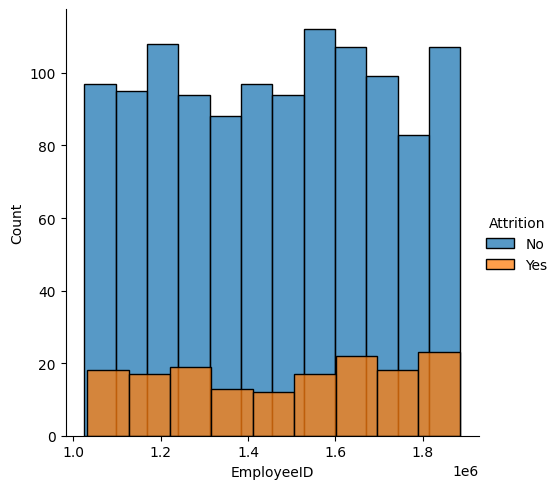

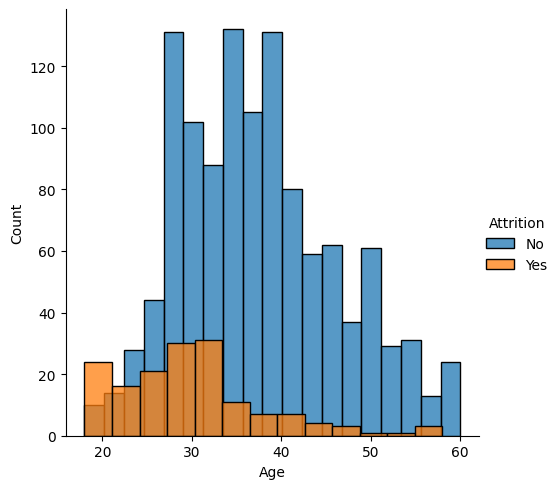

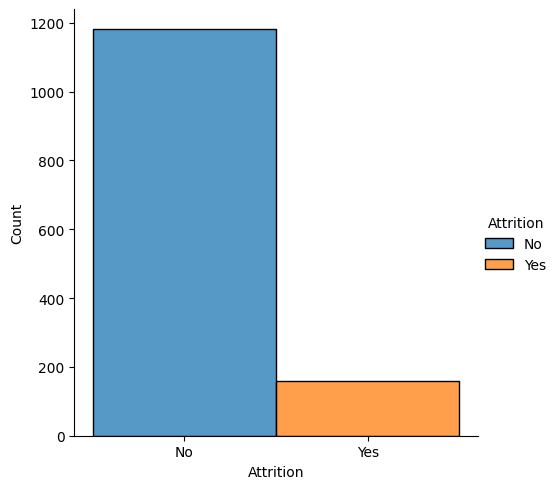

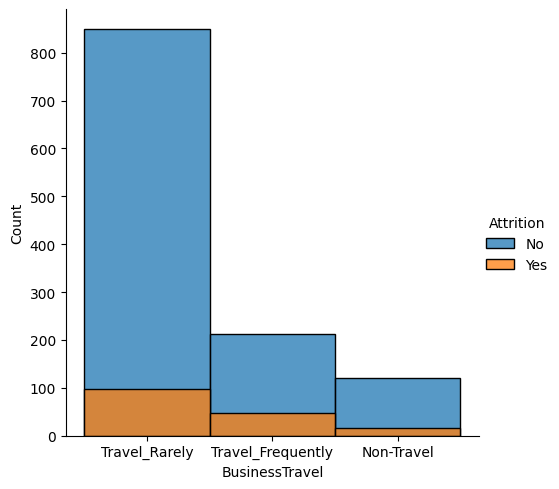

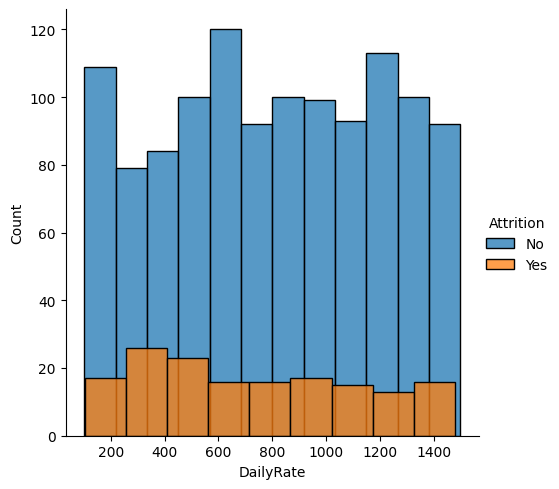

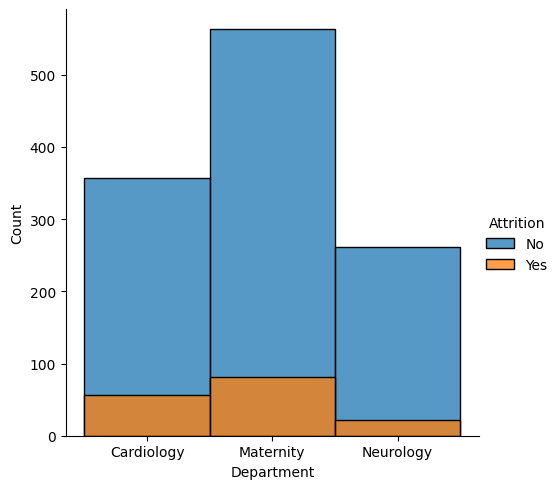

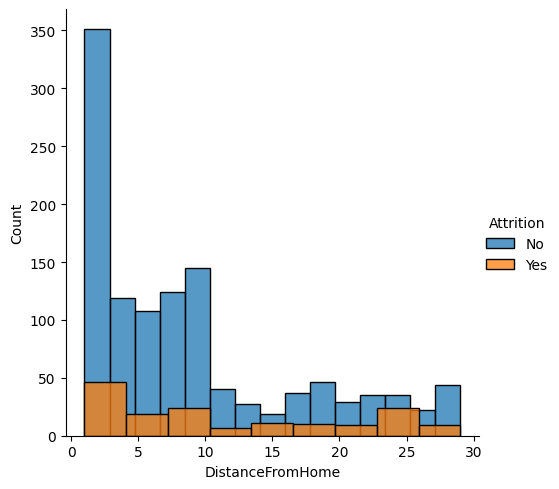

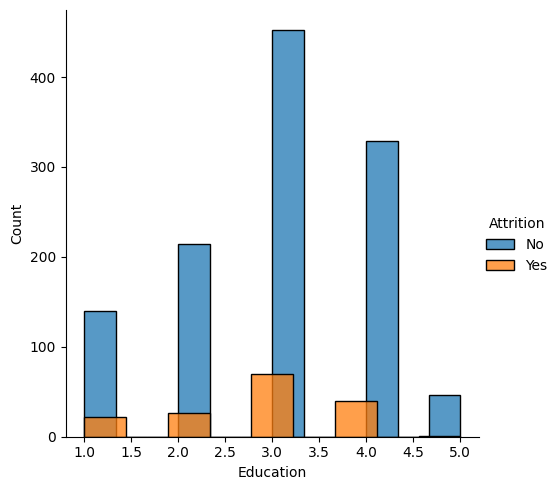

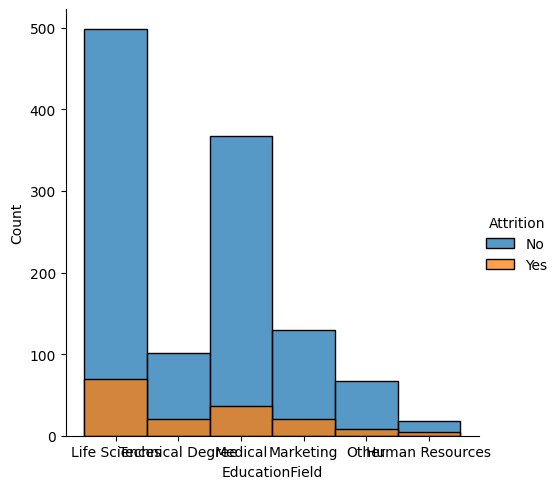

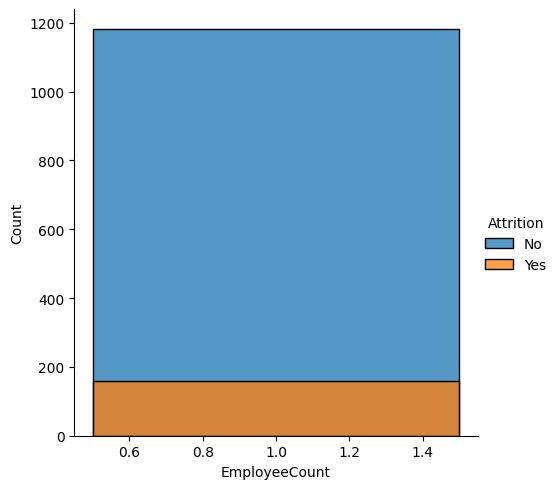

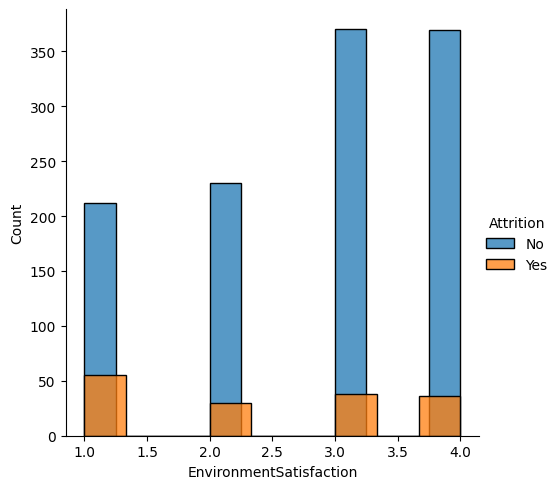

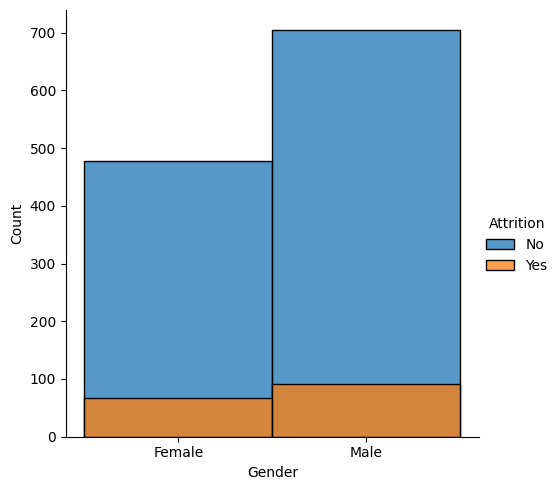

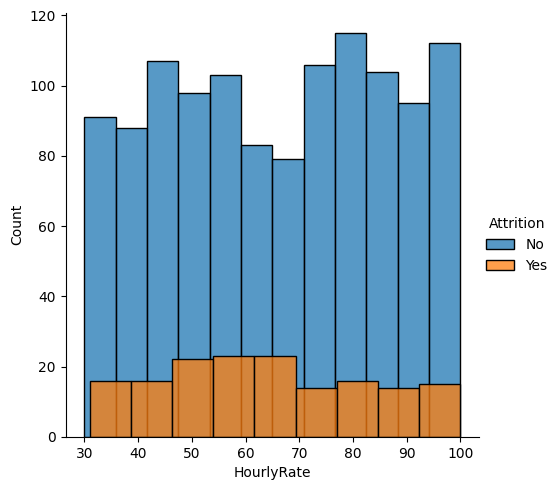

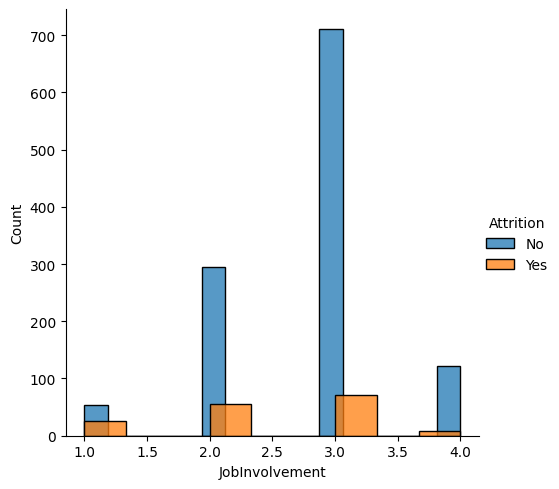

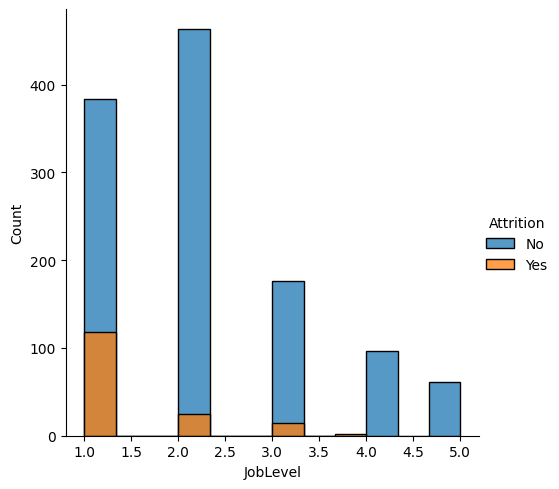

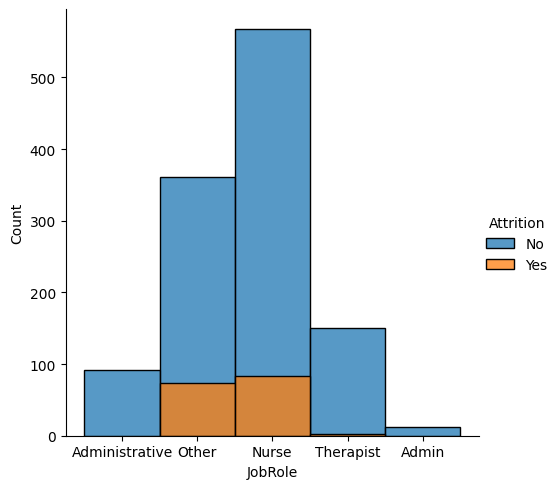

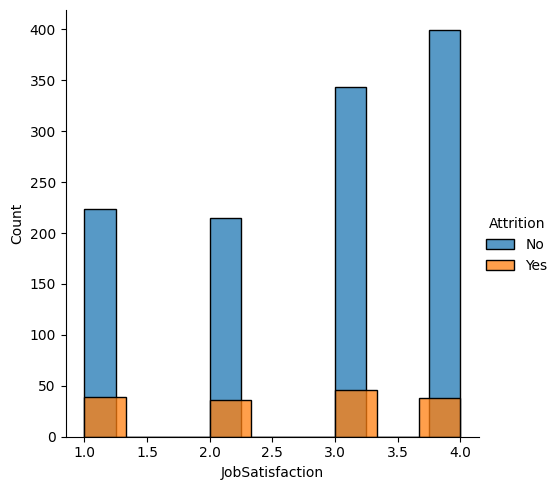

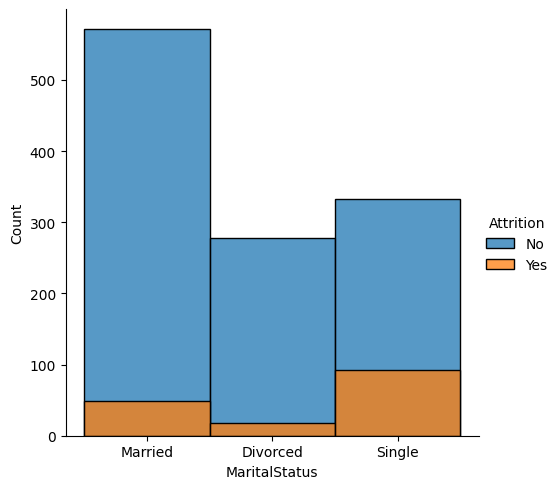

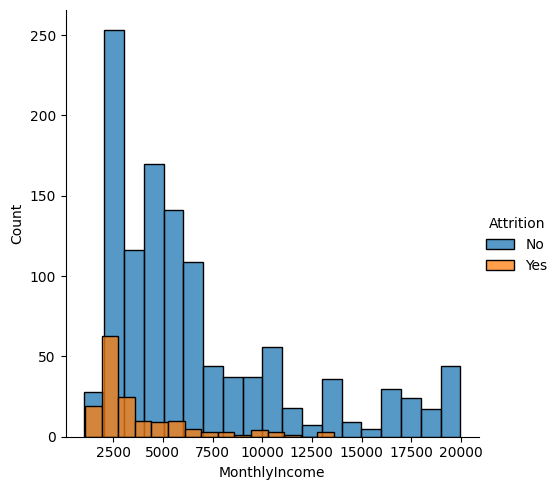

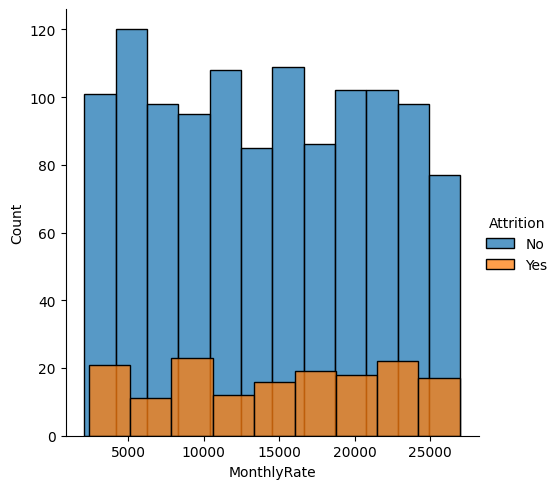

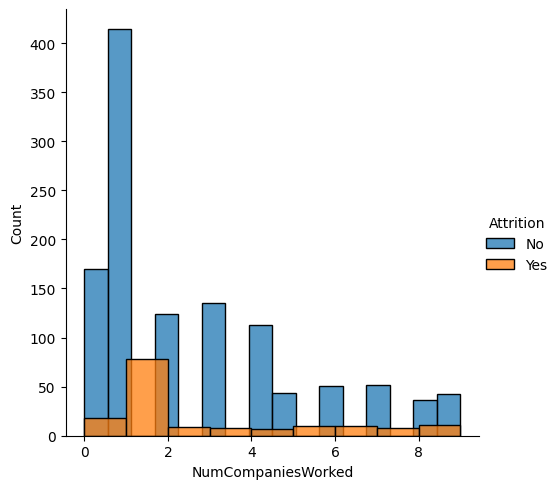

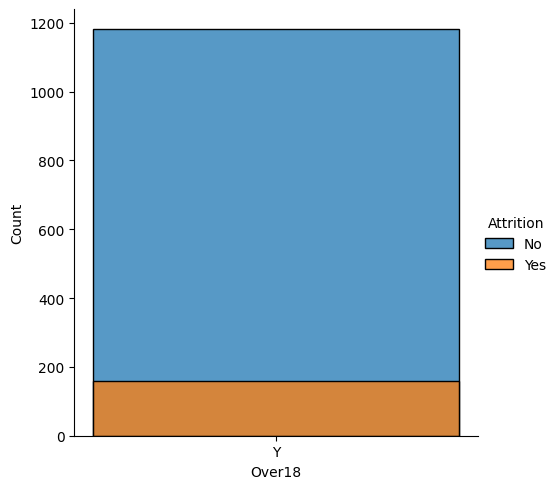

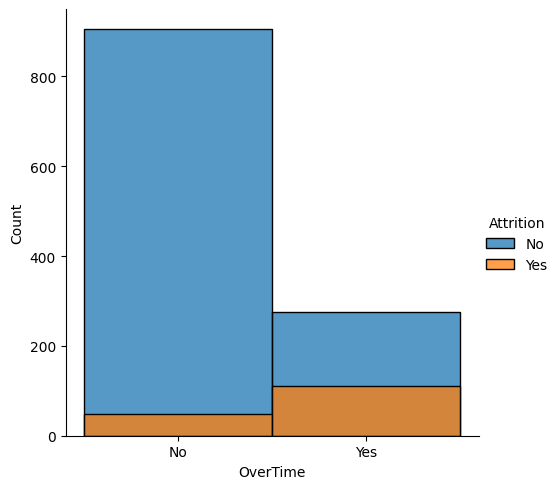

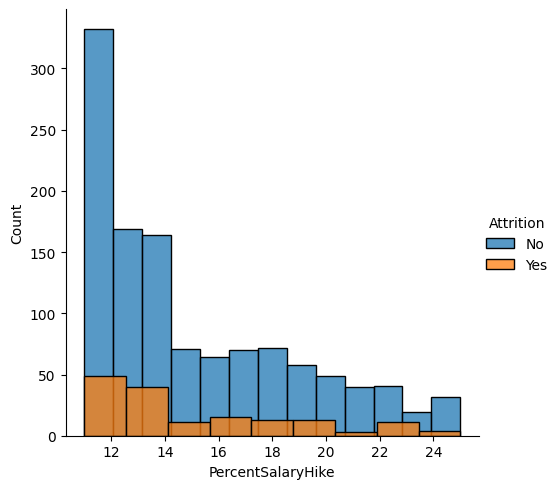

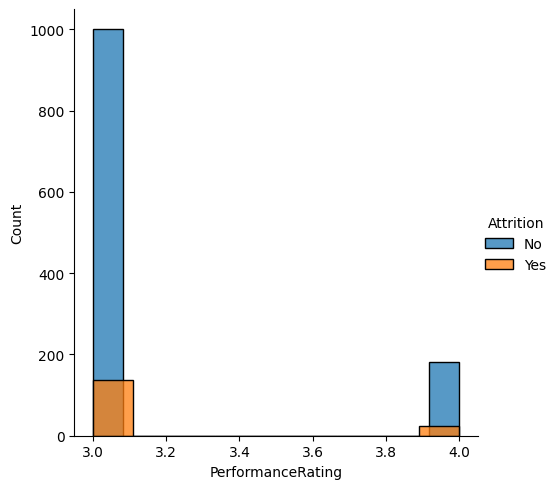

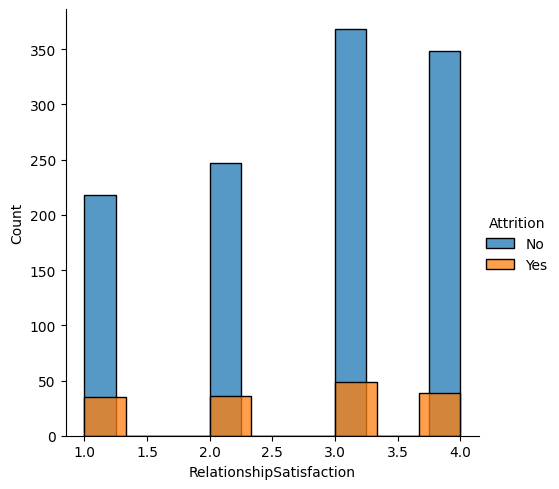

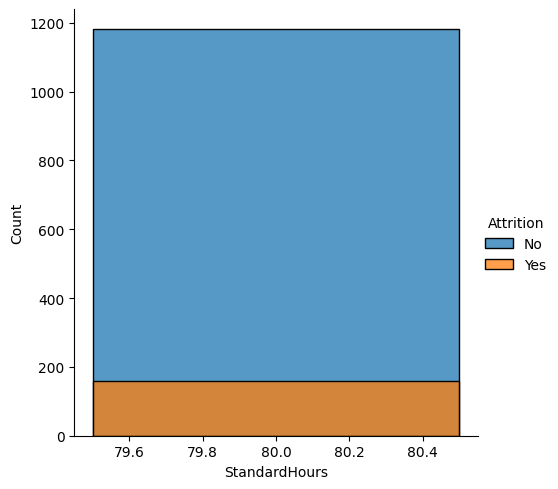

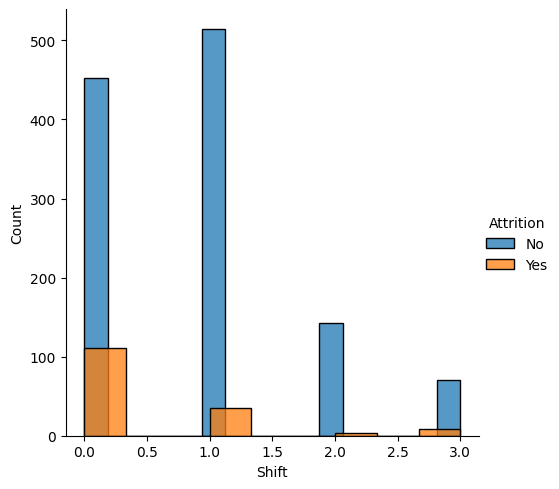

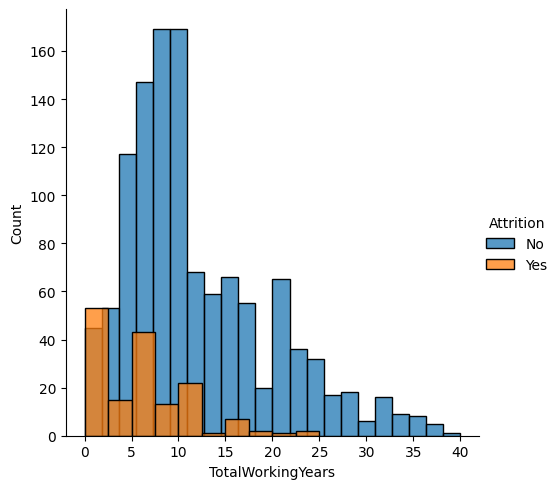

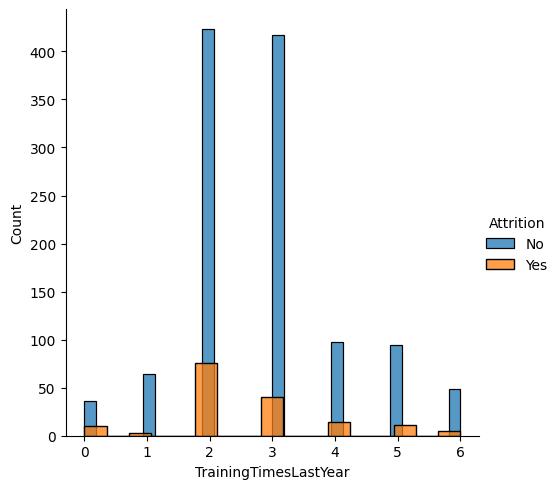

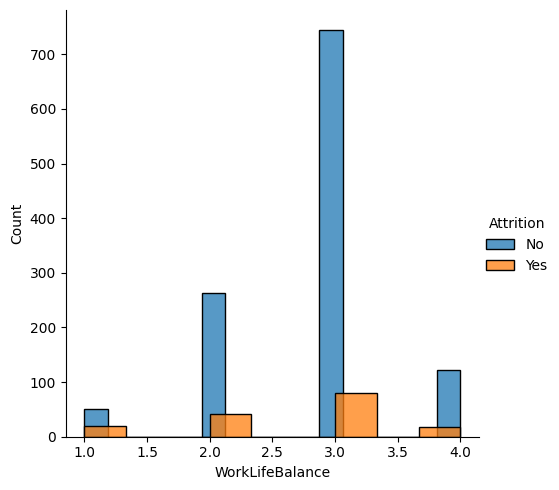

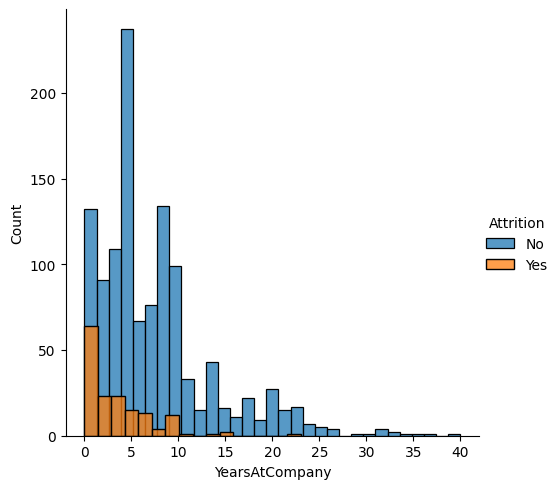

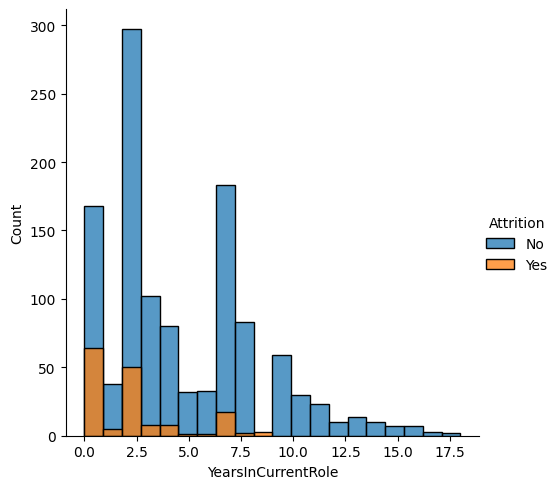

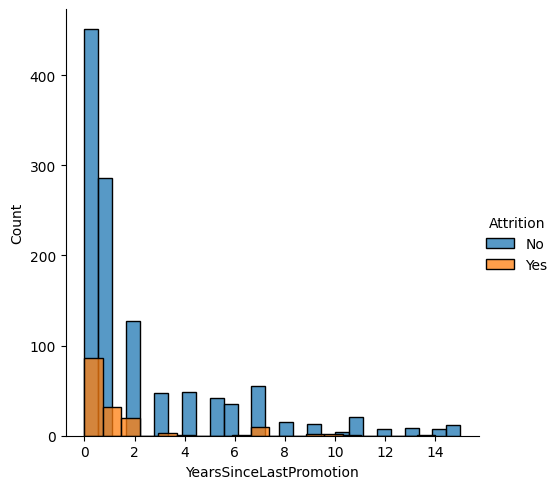

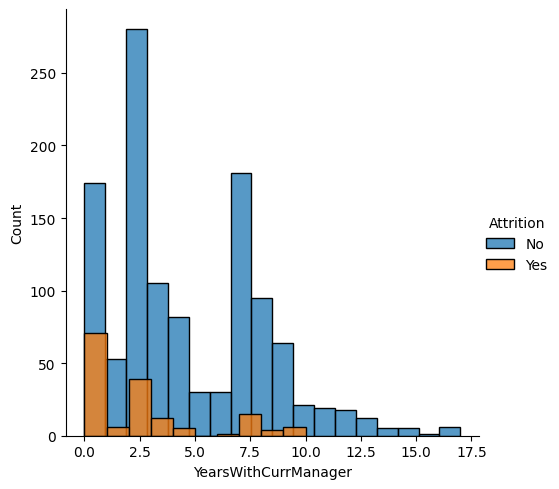

In [153]:
### Initial dataset visualization with histograms
for c in data.columns:
    sns.FacetGrid(data, 
                  hue="Attrition", 
                  height= 5).map(sns.histplot,c).add_legend()

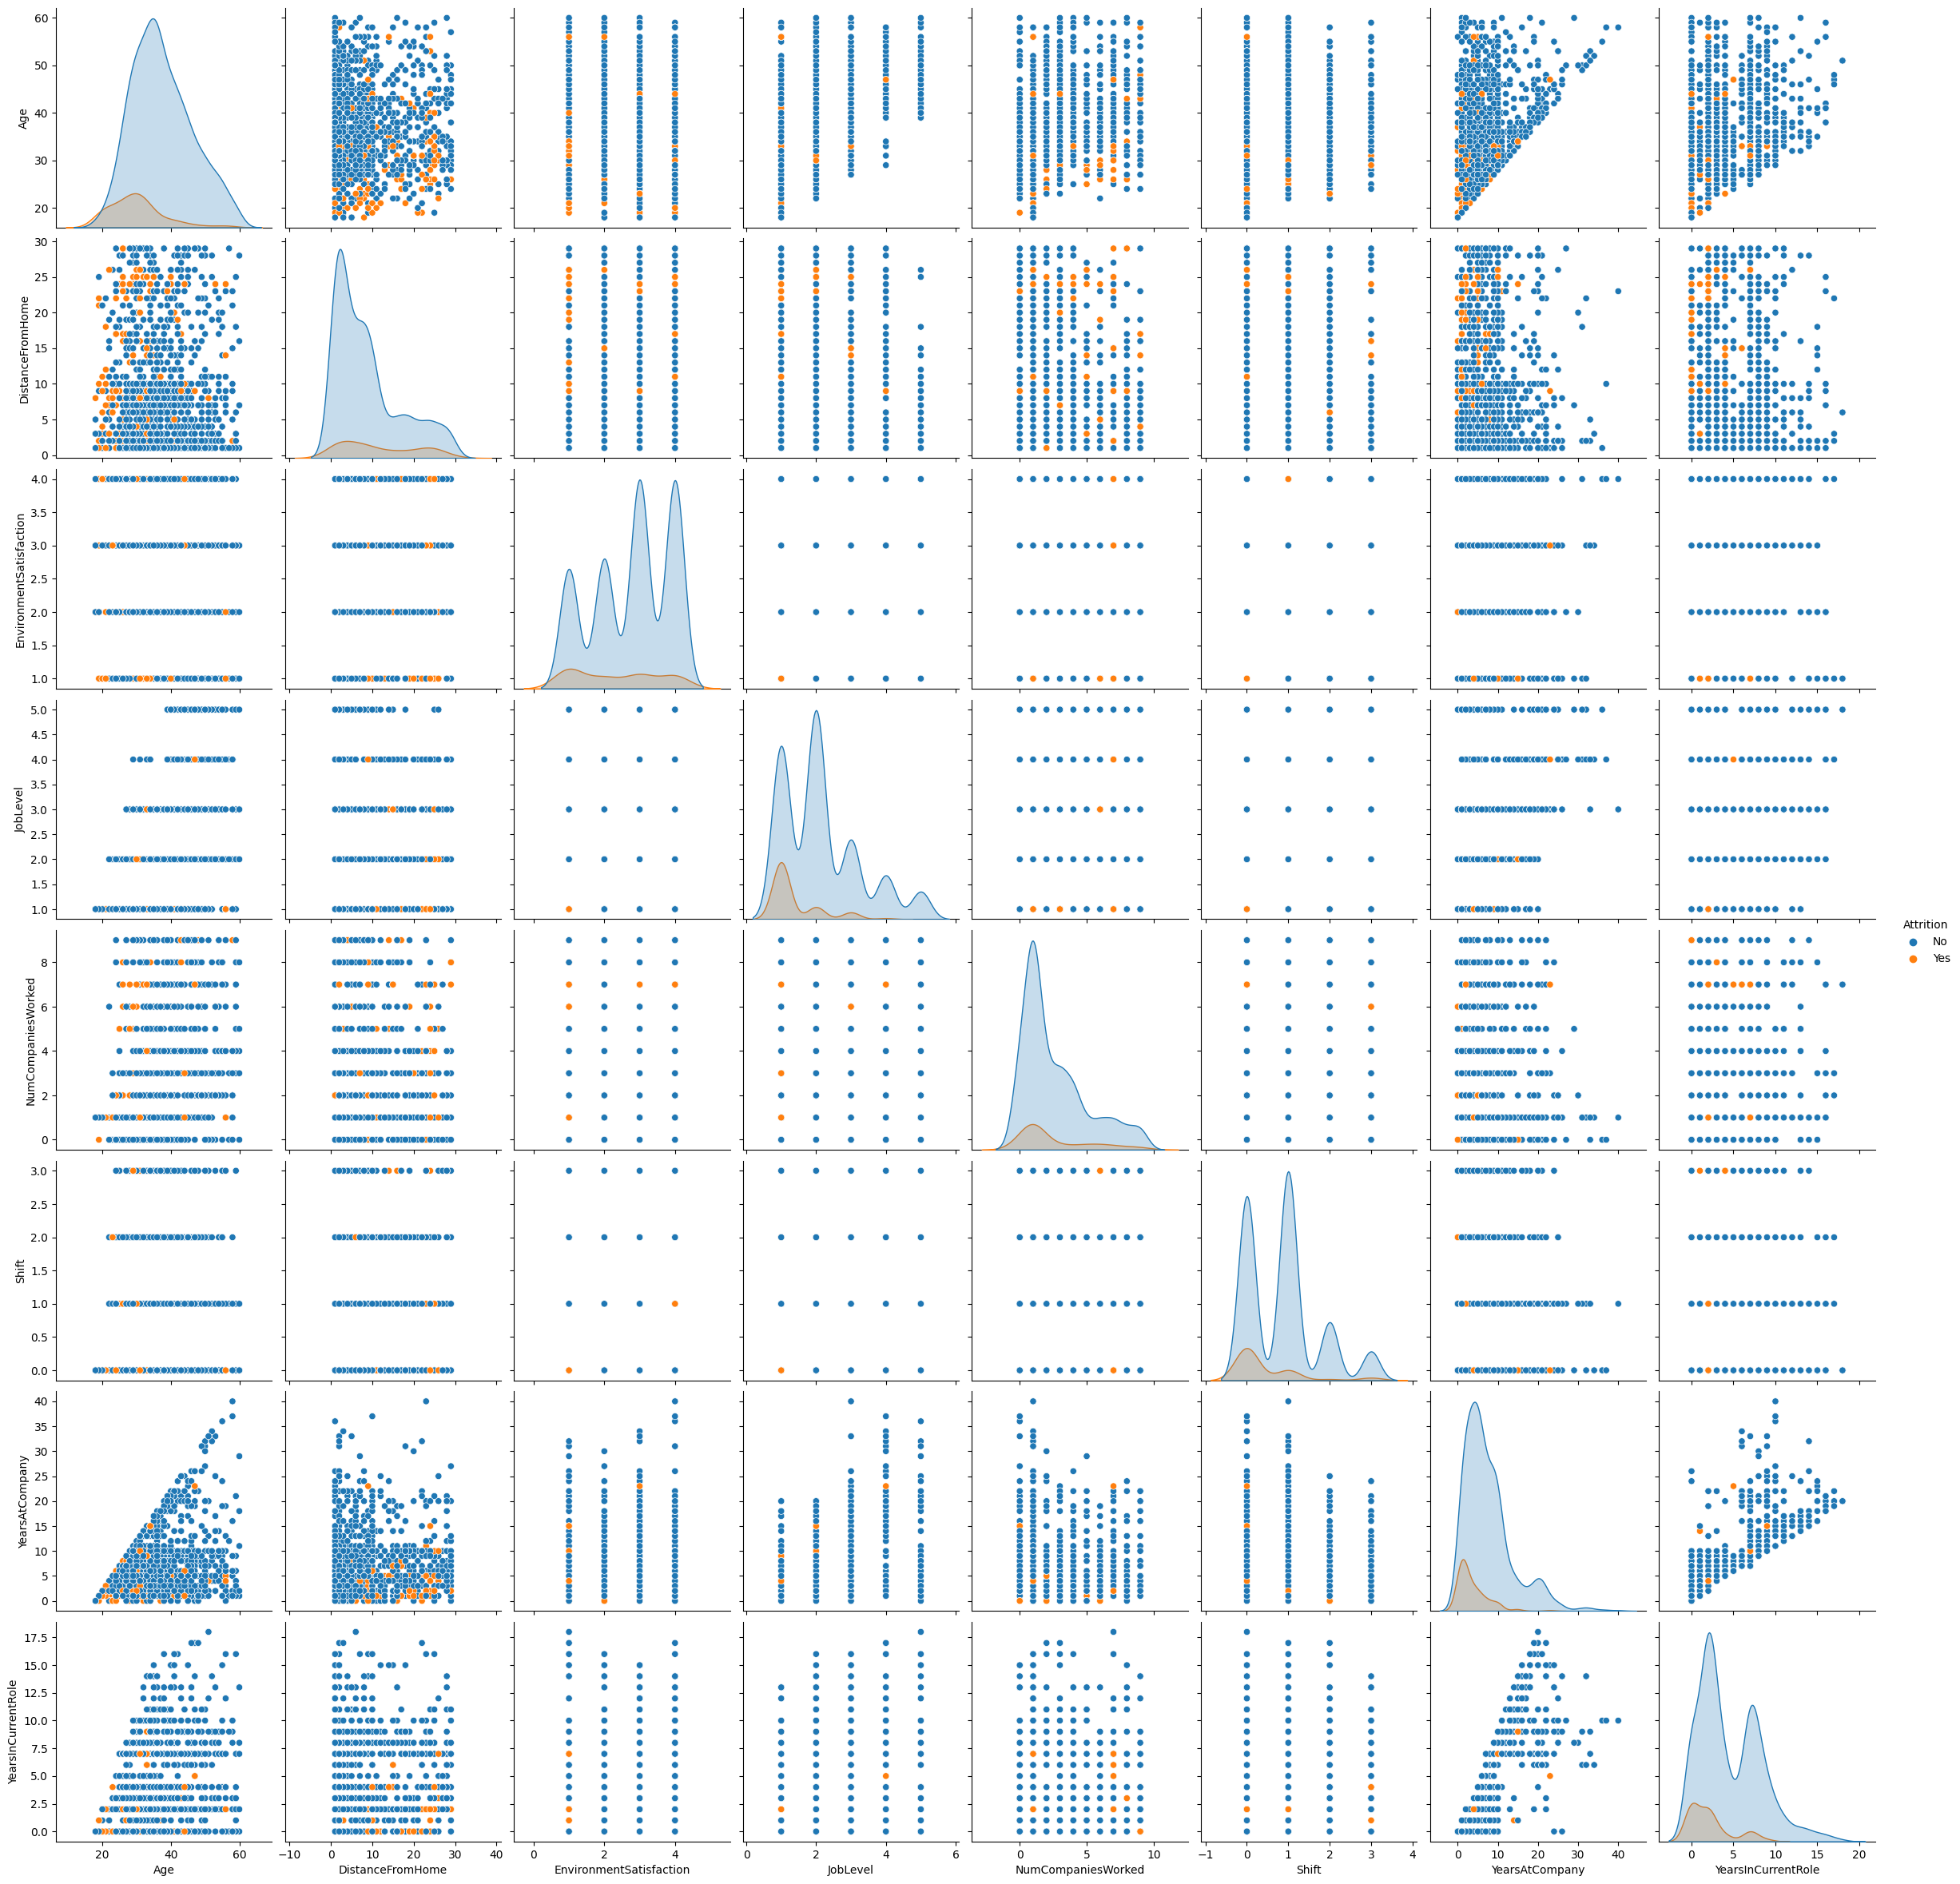

In [154]:
# Make pairwise scatter plots promising features seen in above analysis
promising_features = ["Age", "DistanceFromHome", 
                      "EnvironmentSatisfaction",
                      "JobLevel", "JobRole", 
                      "MaritalStatus", 
                      "NumCompaniesWorked", "OverTime",
                      "Shift", "YearsAtCompany",
                      "YearsInCurrentRole",
                      "Attrition"]

promising_data = data[promising_features]

sns.pairplot(promising_data, 
             hue="Attrition", height= 3)

In [155]:
# Import other data
labels = data.pop("Attrition")
submission_data = pd.read_csv("test.csv")
print(data.shape)
print(submission_data.shape)

(1340, 34)
(336, 34)


In [156]:
# drop columns with only 1 unique value
for c in data.columns:
    print(c, " num unique values: ", len(data[c].unique()), "\n")
    if len(data[c].unique()) == 1:
        data.drop([c], axis=1, inplace=True)
        submission_data.drop([c], axis=1, inplace=True)
print(data.shape)
print(submission_data.shape)


EmployeeID  num unique values:  1340 

Age  num unique values:  43 

BusinessTravel  num unique values:  3 

DailyRate  num unique values:  793 

Department  num unique values:  3 

DistanceFromHome  num unique values:  29 

Education  num unique values:  5 

EducationField  num unique values:  6 

EmployeeCount  num unique values:  1 

EnvironmentSatisfaction  num unique values:  4 

Gender  num unique values:  2 

HourlyRate  num unique values:  71 

JobInvolvement  num unique values:  4 

JobLevel  num unique values:  5 

JobRole  num unique values:  5 

JobSatisfaction  num unique values:  4 

MaritalStatus  num unique values:  3 

MonthlyIncome  num unique values:  1134 

MonthlyRate  num unique values:  1191 

NumCompaniesWorked  num unique values:  10 

Over18  num unique values:  1 

OverTime  num unique values:  2 

PercentSalaryHike  num unique values:  15 

PerformanceRating  num unique values:  2 

RelationshipSatisfaction  num unique values:  4 

StandardHours  num unique 

See that there are 9 categorical columns which need to be converted to numerical.

See that there are many numerical columns which need to be binned by quantile.

Dropped columns with only 1 unique value -> can't get any information from those.

Can see that there are no null values, so we do not need to clean out rows or columns containing nulls.

In [157]:
# Binning
int_cols = []
for c in data.columns:
    if data[c].dtype == "int64":
        print(c, len(data[c].unique()))
        print(data[c].describe(), "\n\n\n")

EmployeeID 1340
count    1.340000e+03
mean     1.460265e+06
std      2.494821e+05
min      1.025177e+06
25%      1.237599e+06
50%      1.469862e+06
75%      1.670131e+06
max      1.886378e+06
Name: EmployeeID, dtype: float64 



Age 43
count    1340.000000
mean       36.580597
std         9.013072
min        18.000000
25%        30.000000
50%        35.000000
75%        42.000000
max        60.000000
Name: Age, dtype: float64 



DailyRate 793
count    1340.000000
mean      799.197761
std       399.333256
min       102.000000
25%       465.000000
50%       796.000000
75%      1153.000000
max      1499.000000
Name: DailyRate, dtype: float64 



DistanceFromHome 29
count    1340.000000
mean        9.193284
std         8.141621
min         1.000000
25%         2.000000
50%         7.000000
75%        14.000000
max        29.000000
Name: DistanceFromHome, dtype: float64 



Education 5
count    1340.000000
mean        2.924627
std         1.036088
min         1.000000
25%         2.000000


In [158]:
# Binning
# found manually 
cols_to_bin = ["Age", "DailyRate", "DistanceFromHome",
               "HourlyRate", "MonthlyIncome", "MonthlyRate",
               "PercentSalaryHike", "TotalWorkingYears",
               "YearsAtCompany","YearsInCurrentRole",
               "YearsWithCurrManager", "NumCompaniesWorked", 
               "YearsSinceLastPromotion",]

print(data.shape)
print(submission_data.shape)

# uneven 4 groups
for c in cols_to_bin:
    try:
        data[c+"_Even"] = pd.cut(data[c], 4, labels=False)
        submission_data[c+"_Even"] = pd.cut(submission_data[c], 4, labels=False)
    except:
        print("failed")
        pass


print(data.shape)
print(submission_data.shape)

(1340, 31)
(336, 31)
(1340, 44)
(336, 44)


In [159]:
# get dummies from int categorical data

# found manually
already_categorical = ["Education", "EnvironmentSatisfaction",
                       "JobInvolvement", "JobLevel", "JobSatisfaction",
                       "PerformanceRating", "RelationshipSatisfaction",
                       "Shift", "TrainingTimesLastYear",
                       "WorkLifeBalance"]

for c in already_categorical:
    temp_dummy = pd.get_dummies(data[c], prefix=c)
    data = pd.concat([data, temp_dummy], axis=1)
    
    sub_temp_dummy = pd.get_dummies(submission_data[c], prefix=c)
    submission_data = pd.concat([submission_data, sub_temp_dummy], axis=1)
    
print(data.shape)
print(submission_data.shape)


(1340, 87)
(336, 87)


In [160]:
# get dummies from obj categorical data
for c in data.columns:
    if data[c].dtype == "object":
        if len(data[c].unique()) == 2:
            data[c] = pd.factorize(data[c])[0]   
            
            submission_data[c] = pd.factorize(submission_data[c])[0] 
        else:
            temp_dummy = pd.get_dummies(data[c], prefix=c)
            data = pd.concat([data, temp_dummy], axis=1)
            data[c] = pd.factorize(data[c])[0]     
            
            sub_temp_dummy = pd.get_dummies(submission_data[c], prefix=c)
            submission_data = pd.concat([submission_data, sub_temp_dummy], axis=1)
            submission_data[c] = pd.factorize(submission_data[c])[0]  

print(data.shape)
print(submission_data.shape)

# turn label column to binary
labels = pd.DataFrame(pd.factorize(labels)[0], columns=["Attrition"])


(1340, 107)
(336, 107)


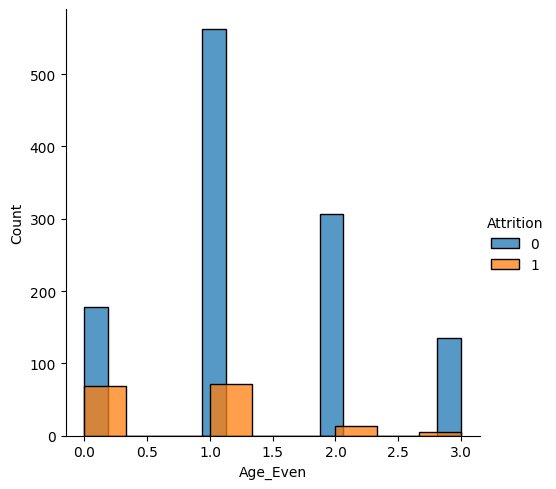

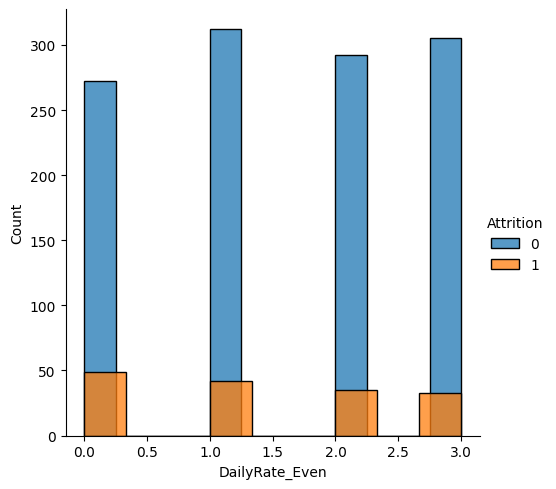

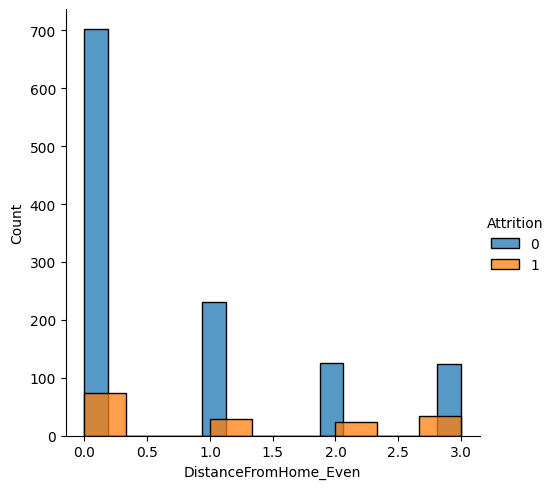

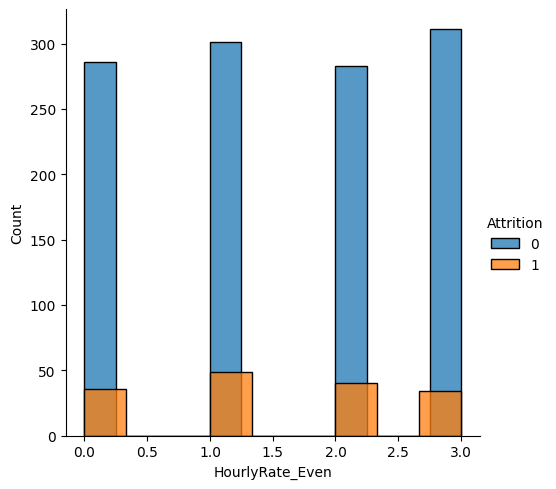

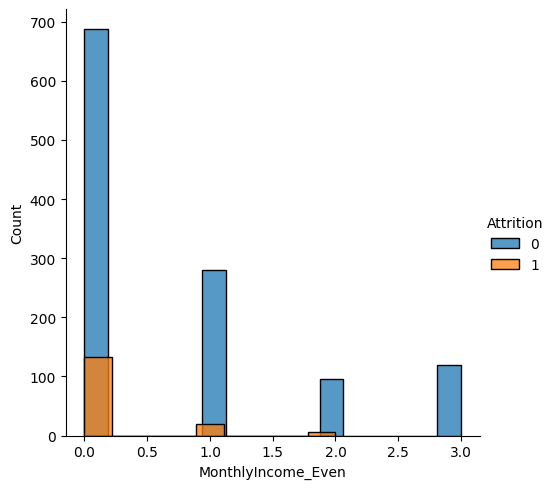

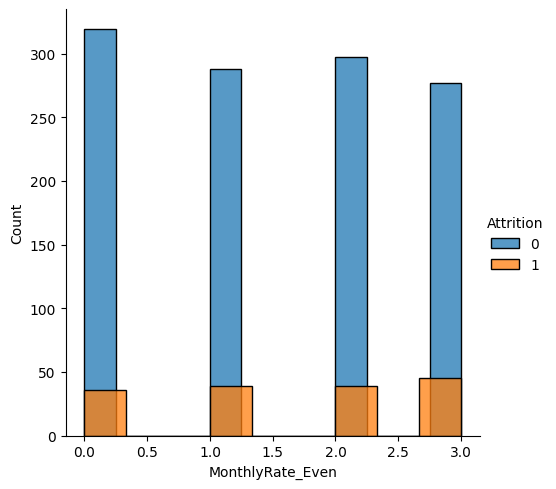

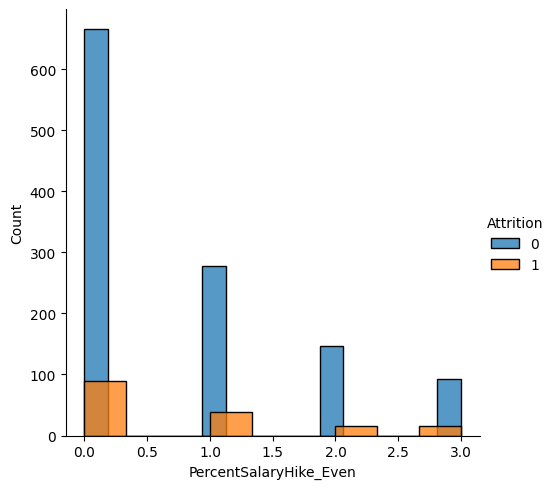

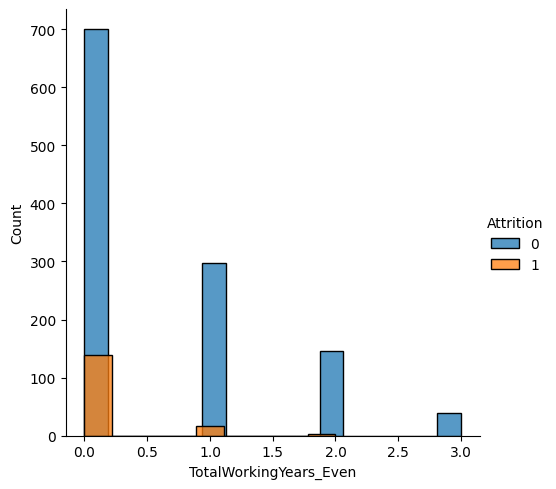

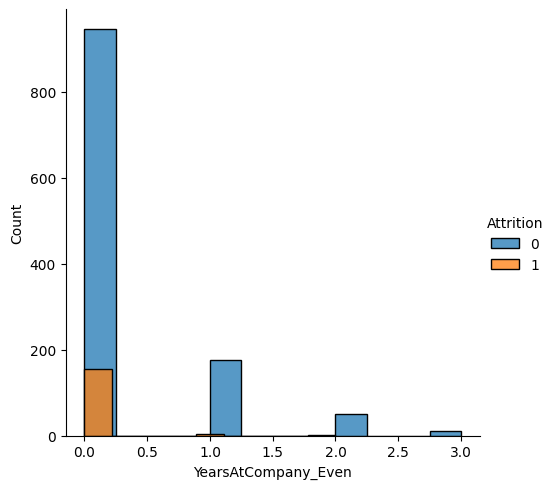

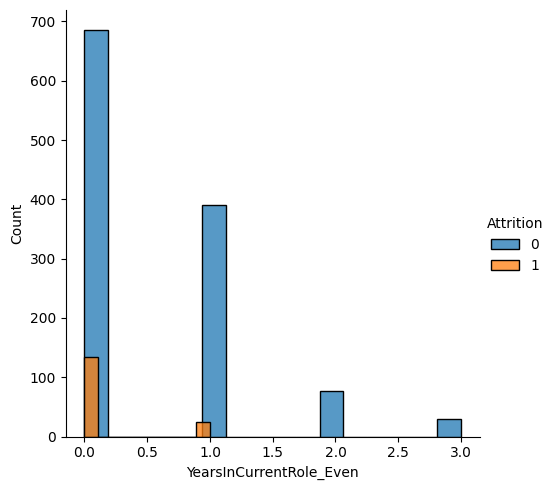

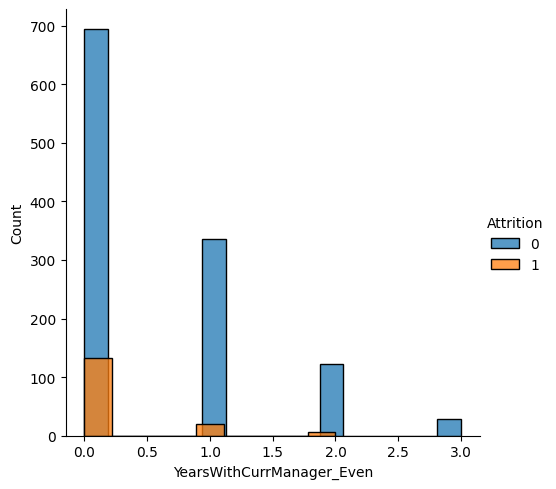

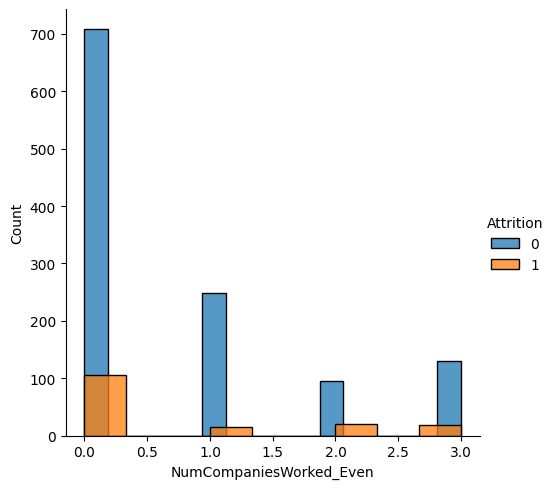

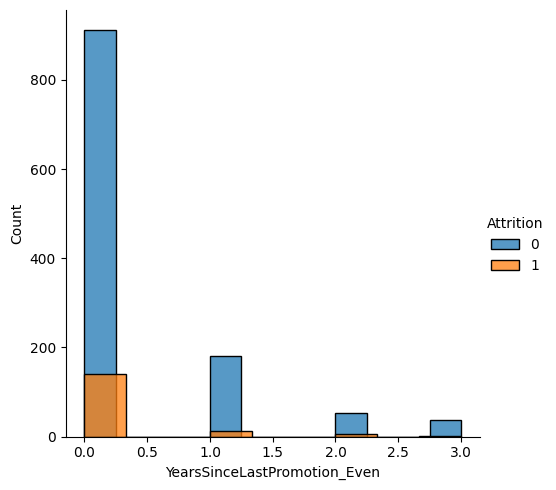

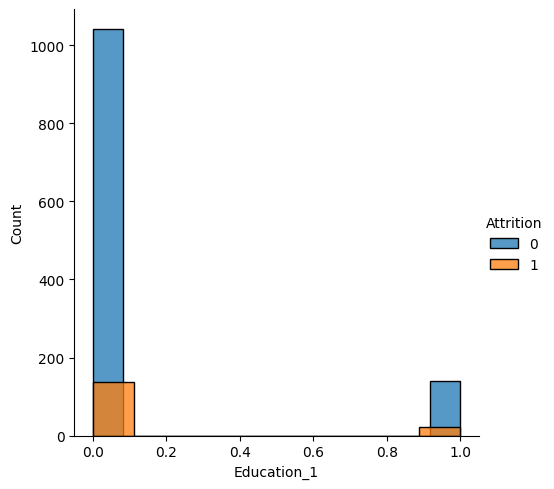

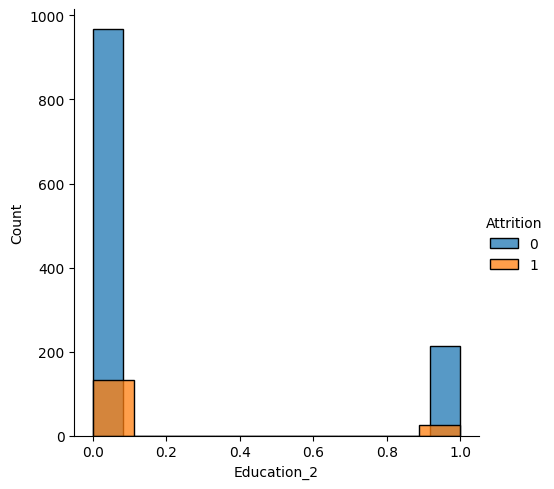

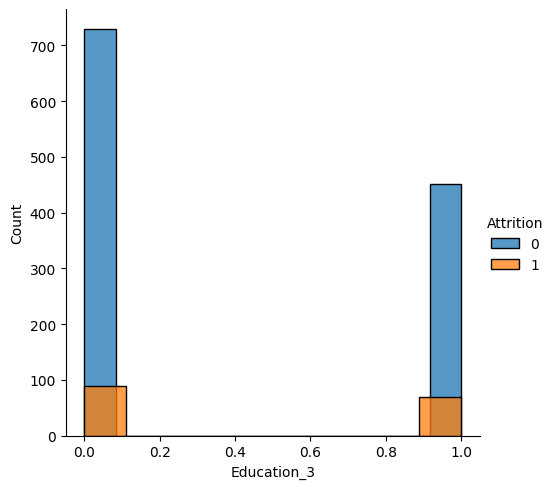

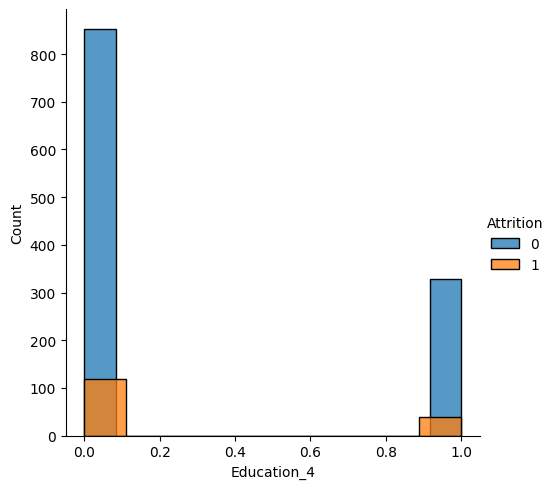

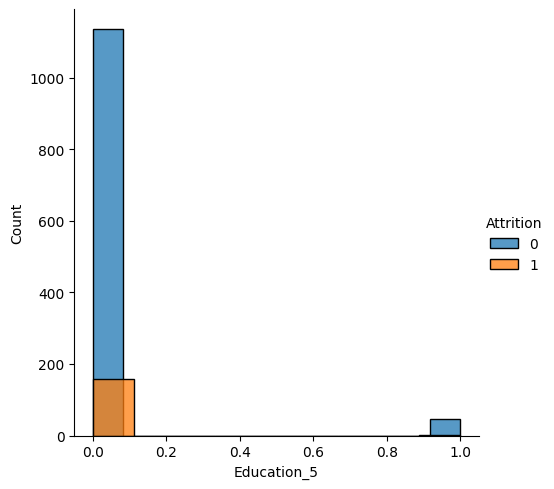

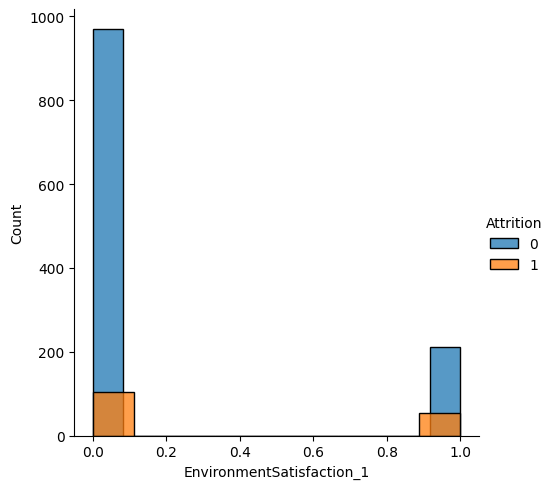

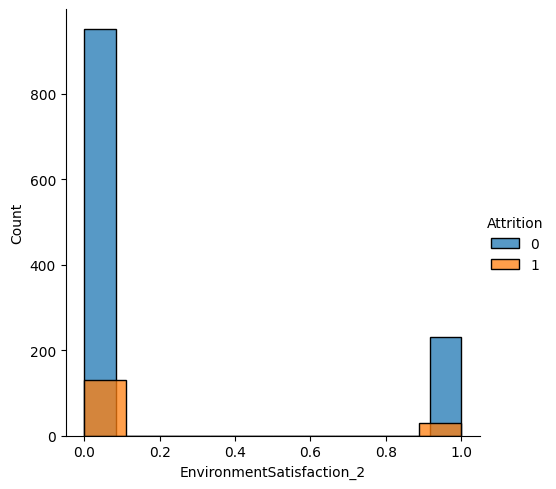

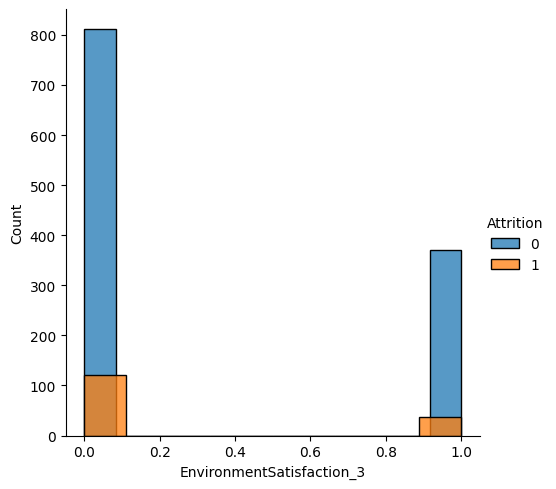

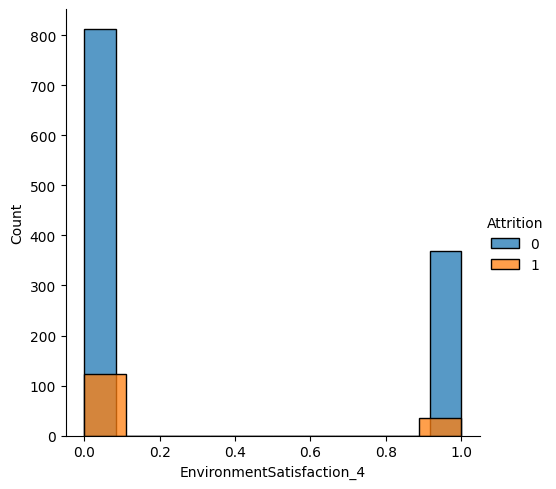

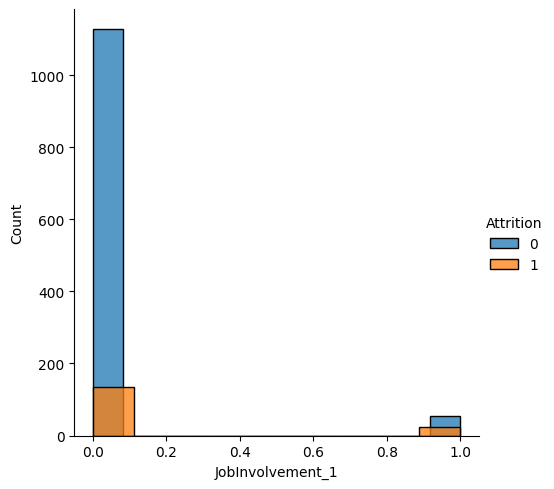

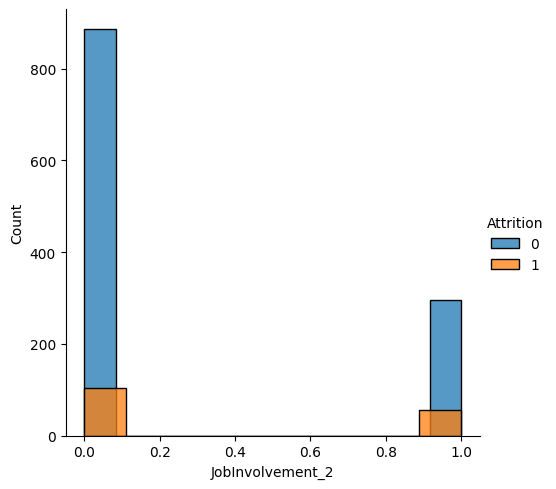

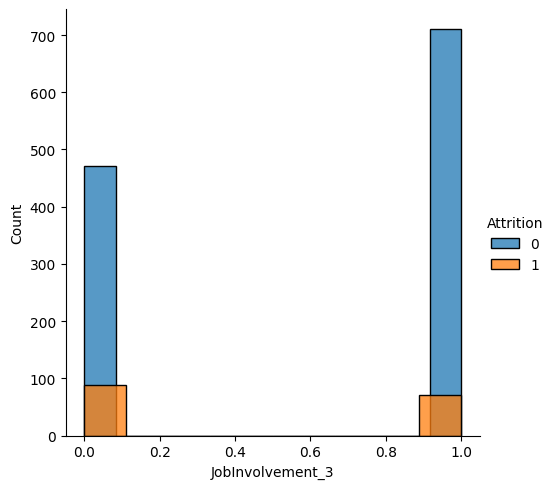

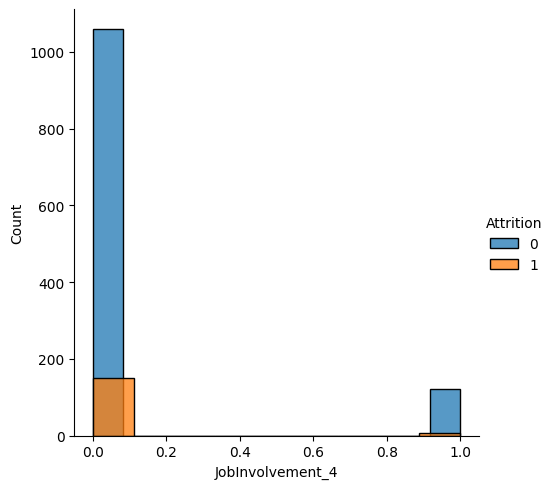

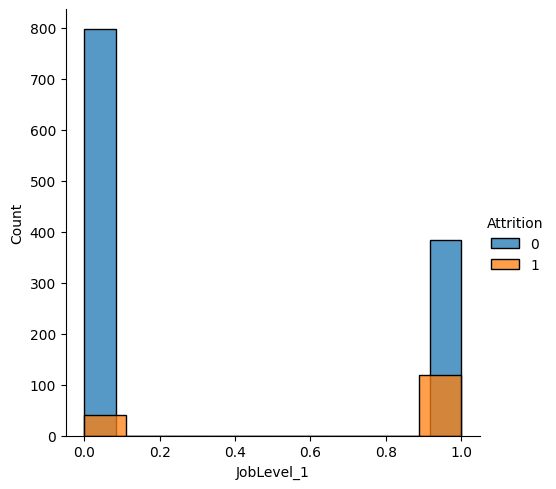

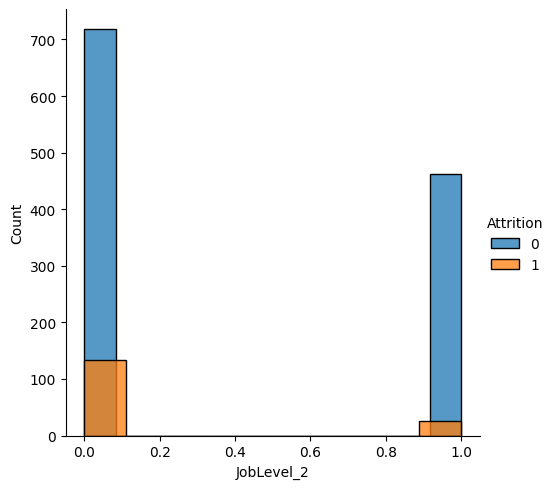

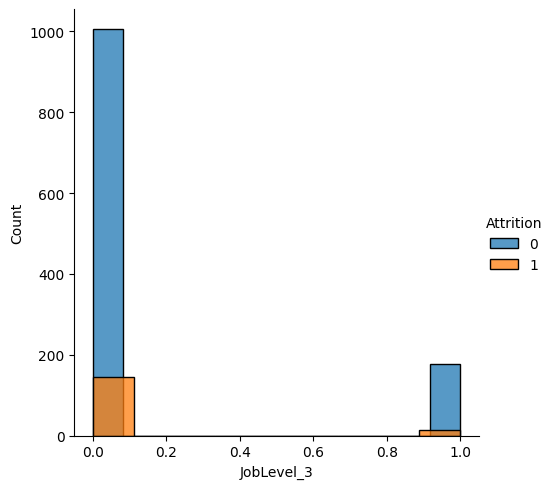

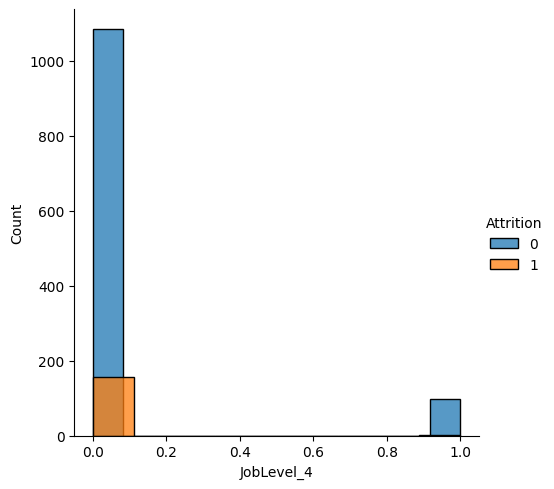

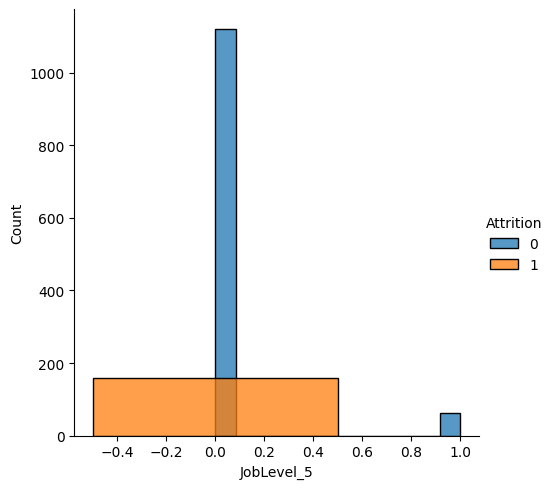

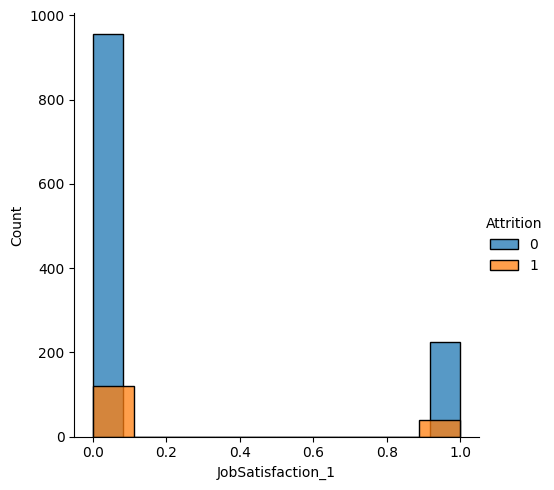

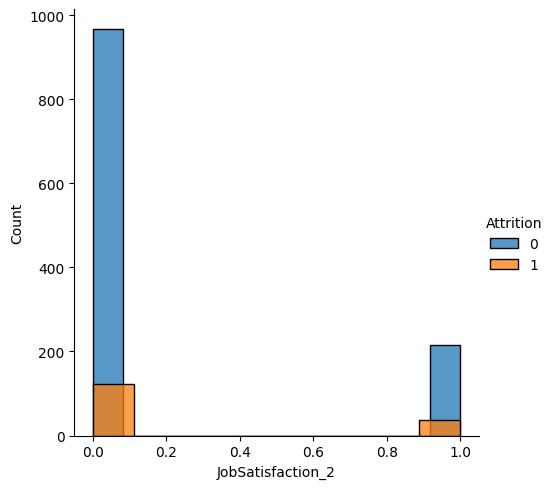

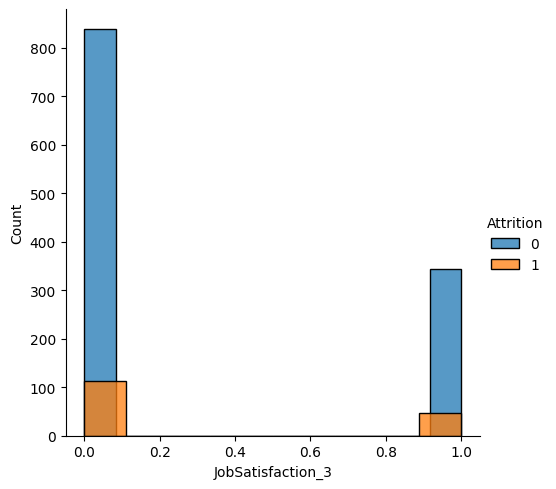

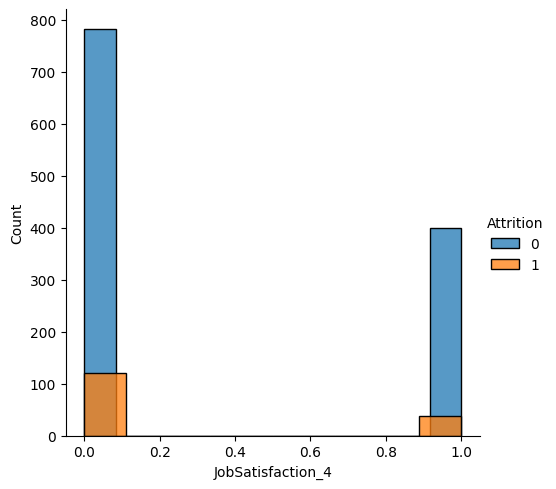

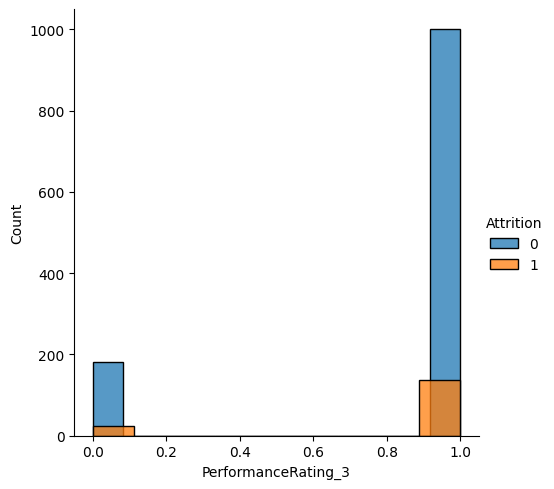

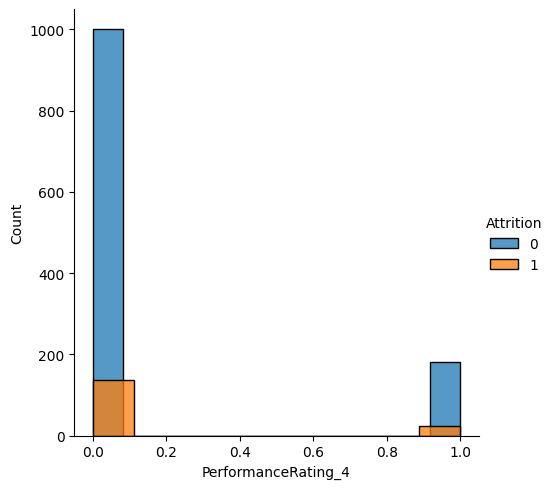

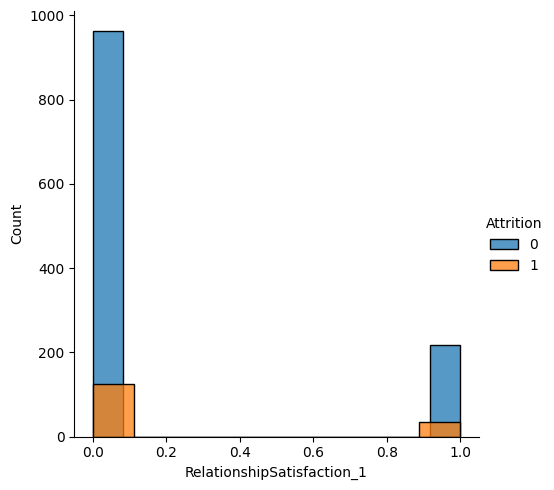

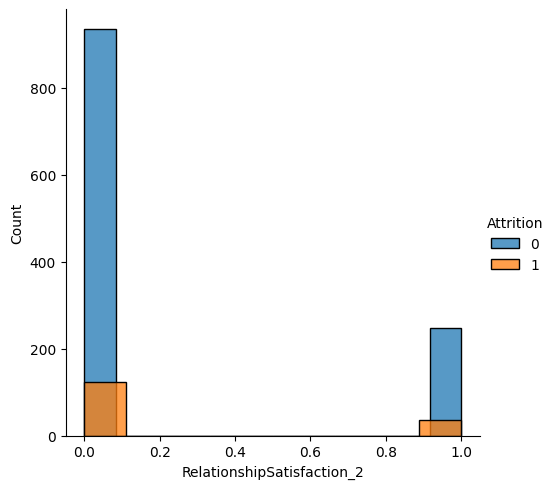

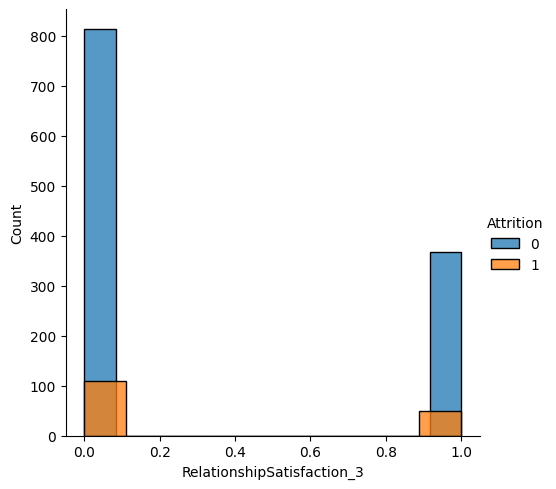

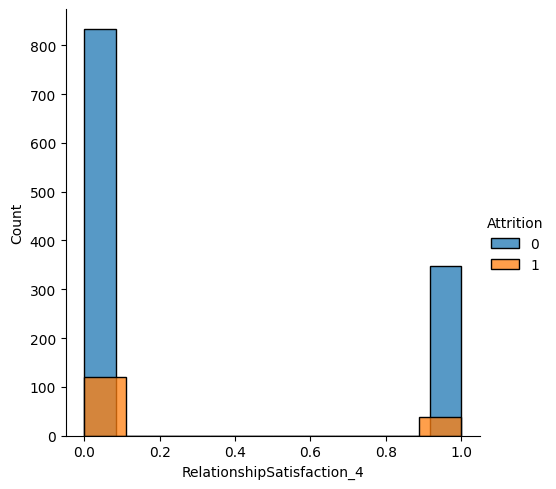

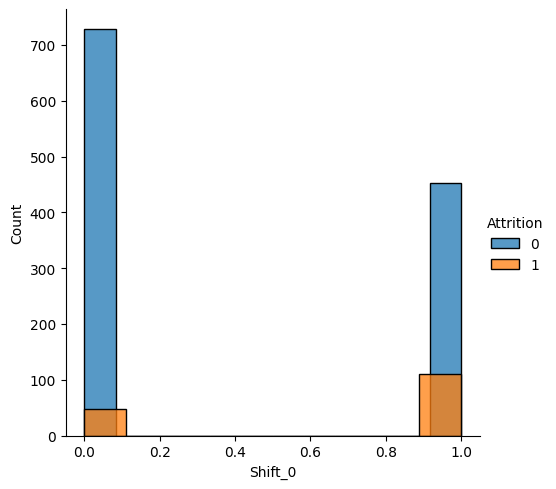

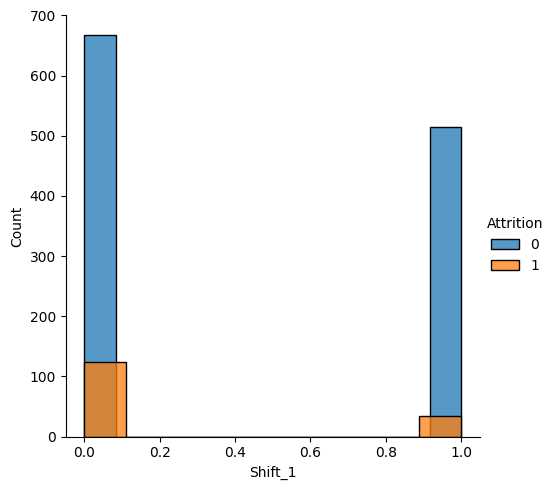

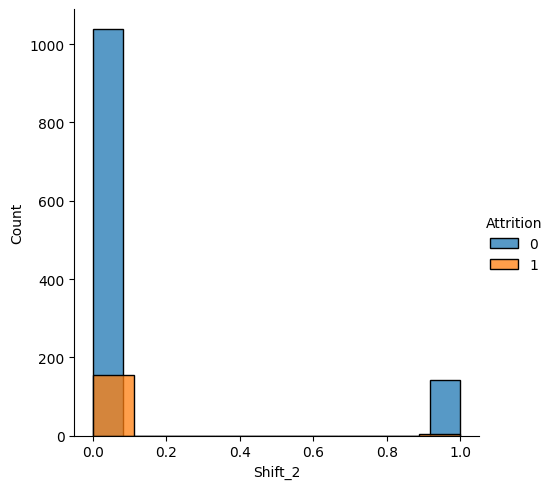

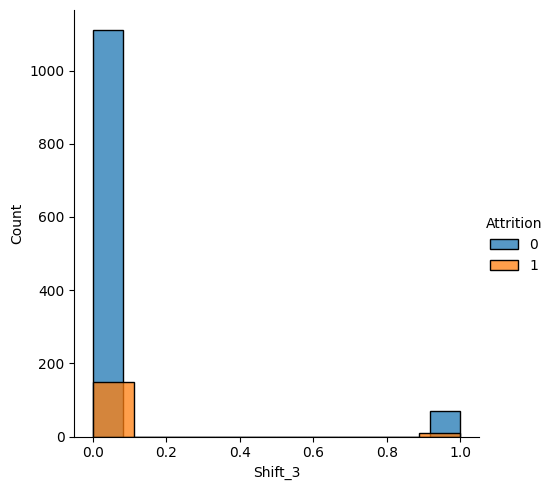

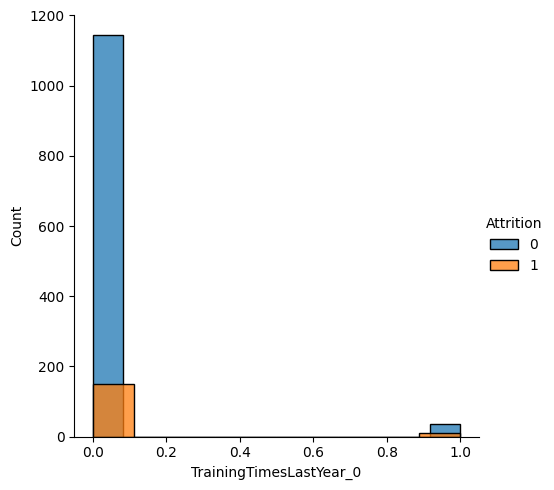

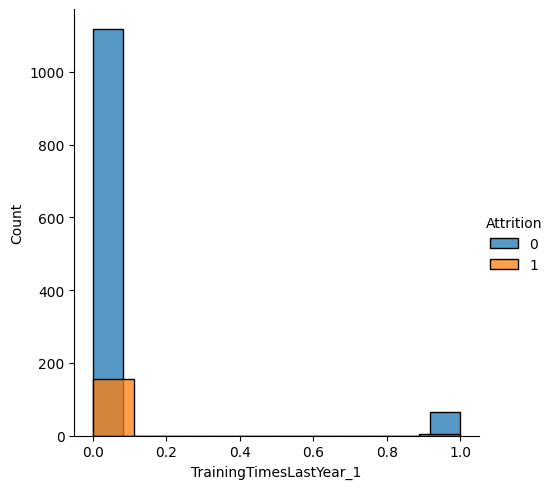

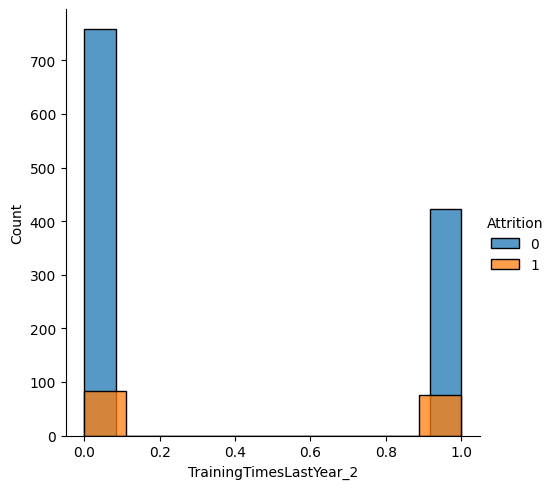

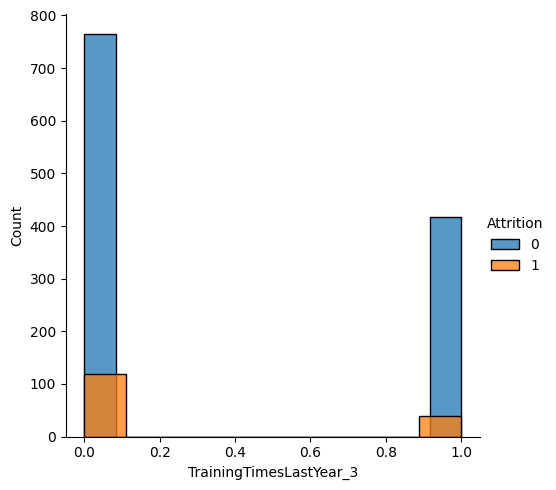

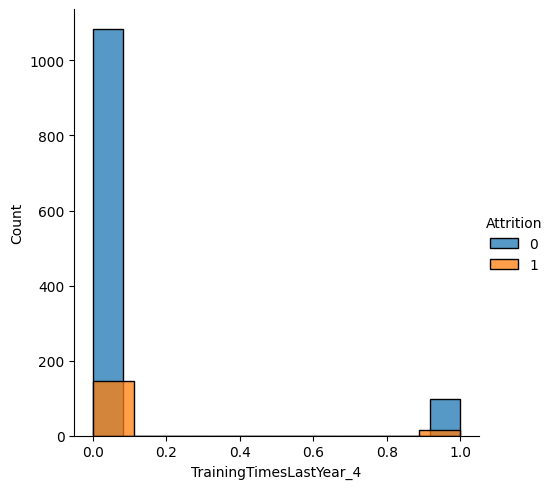

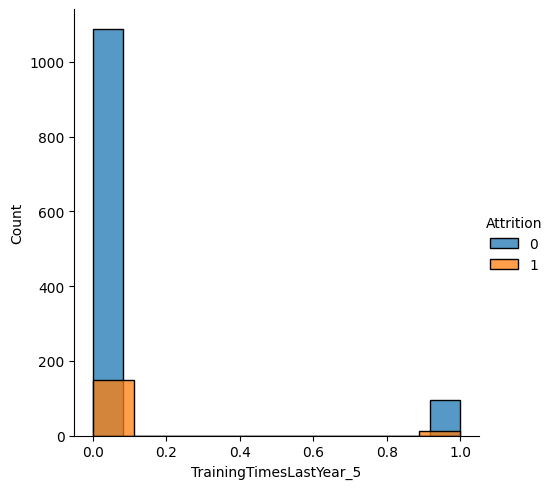

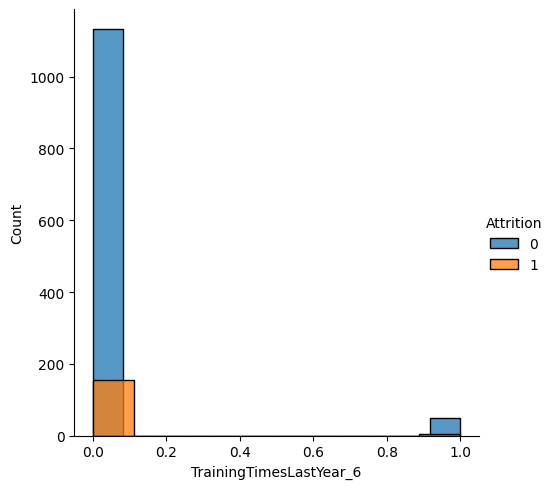

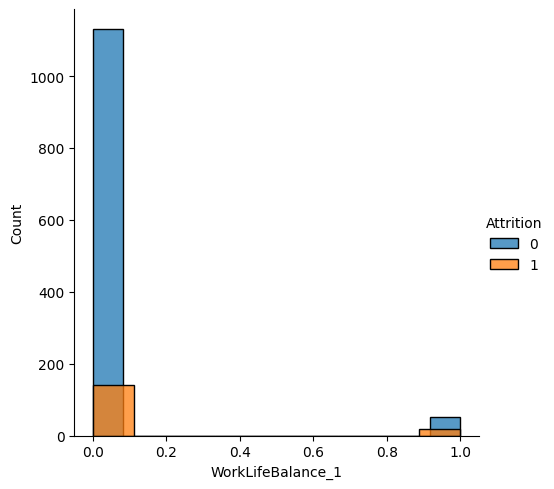

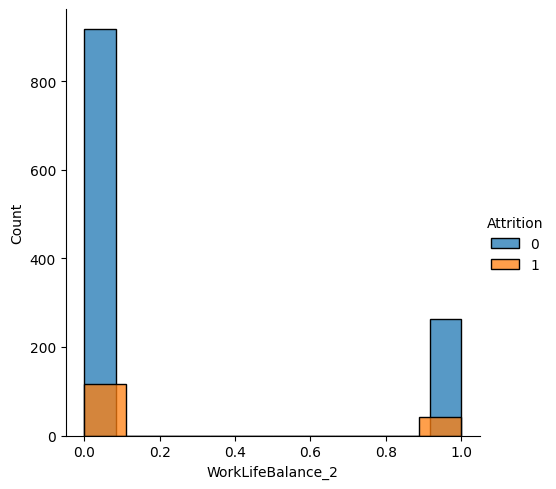

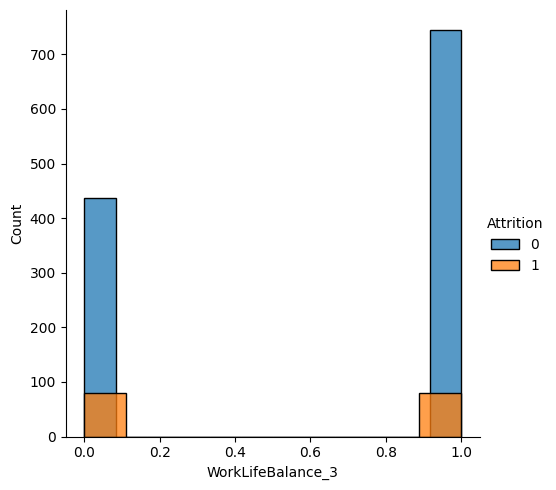

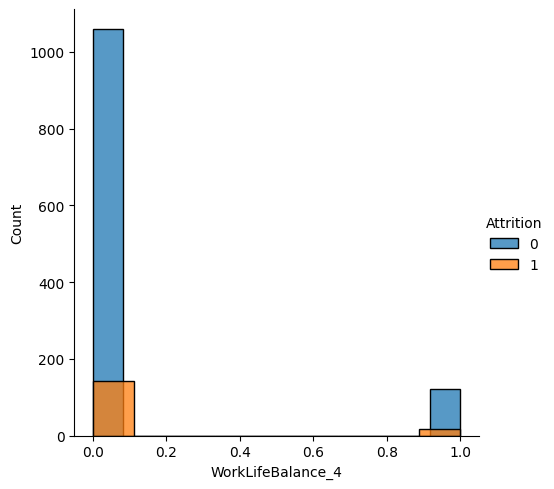

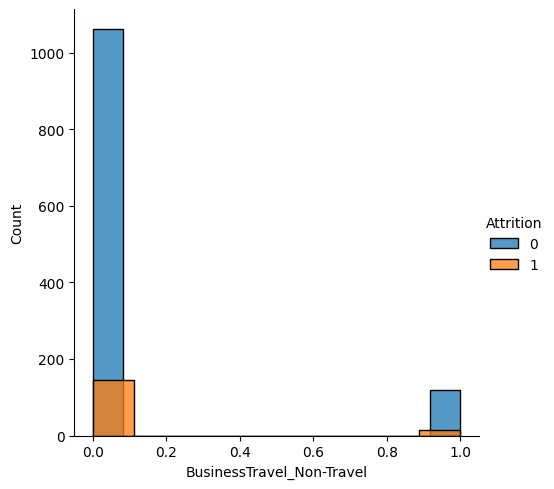

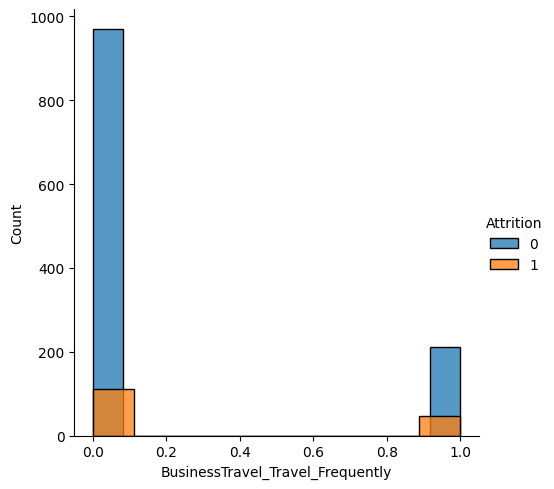

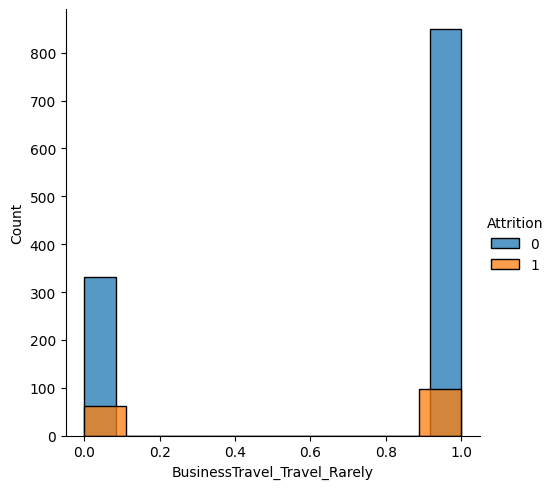

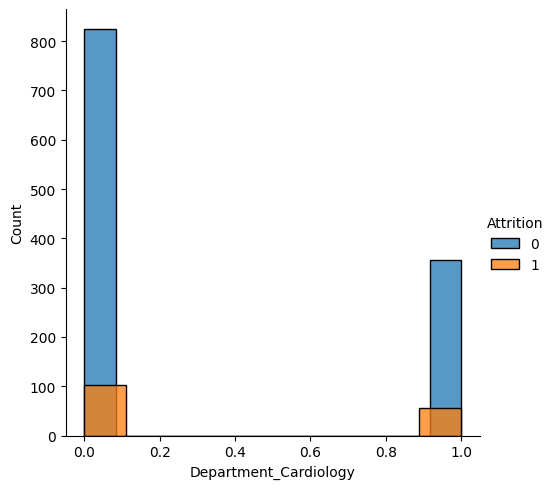

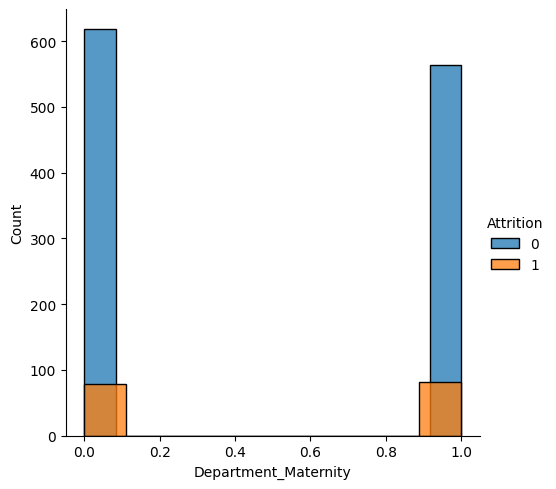

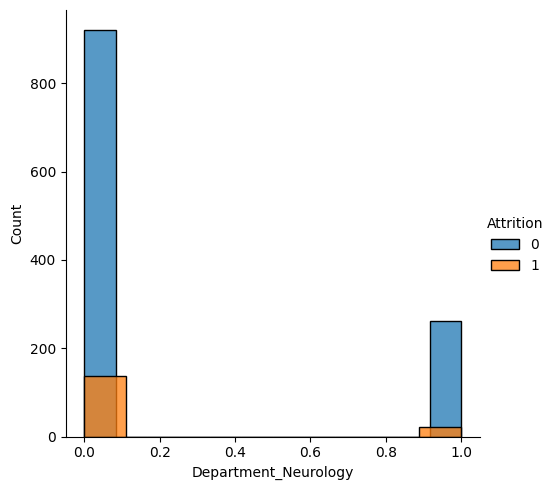

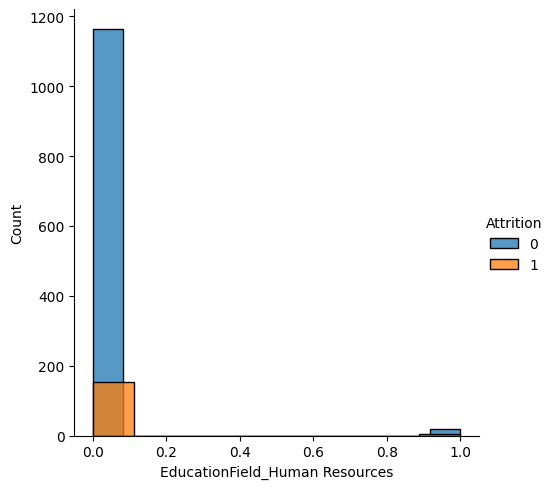

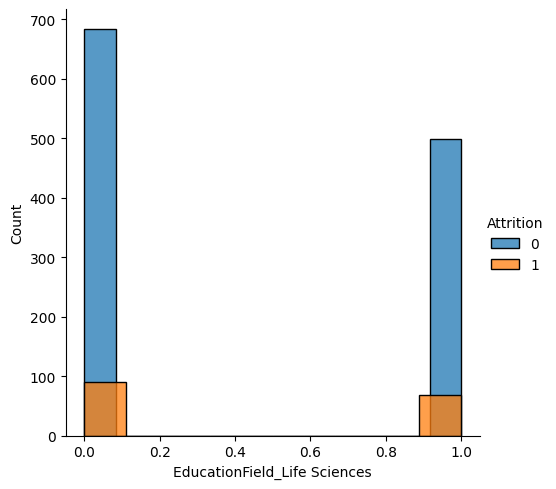

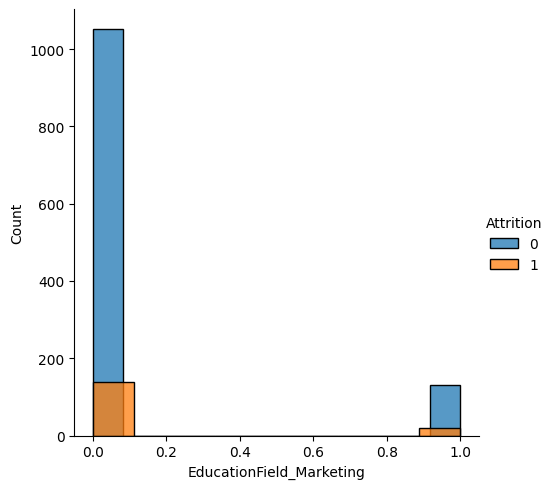

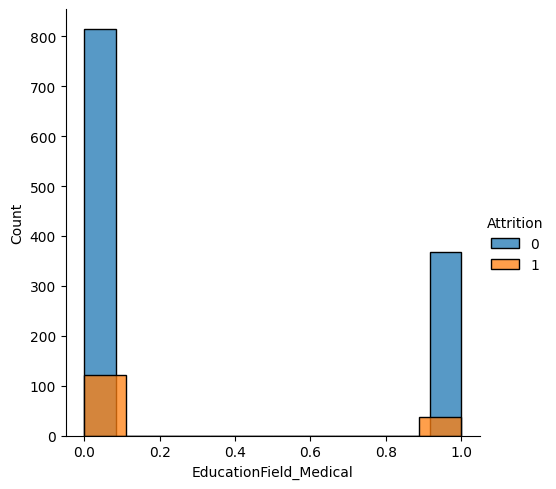

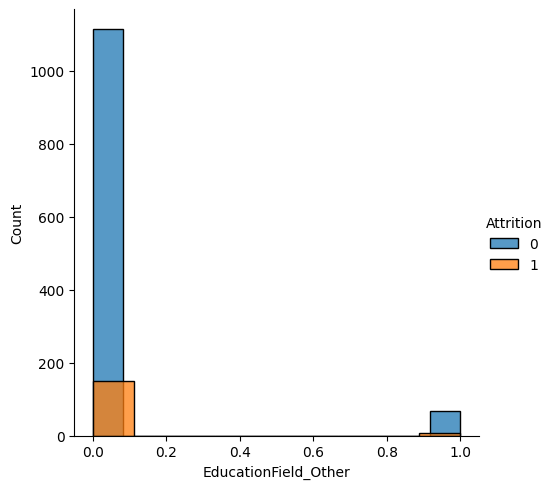

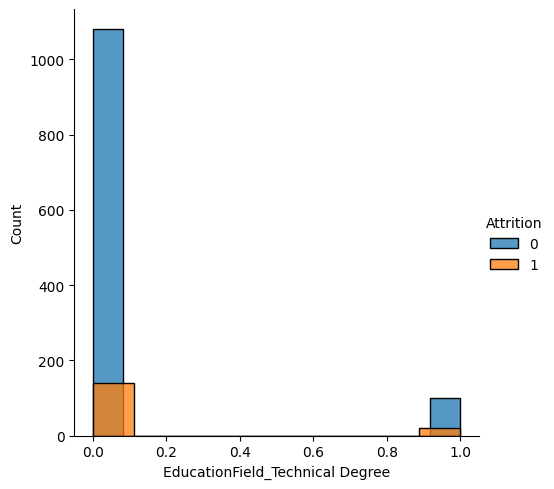

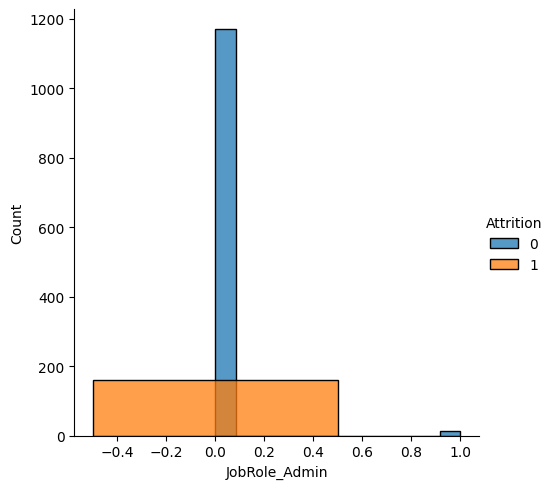

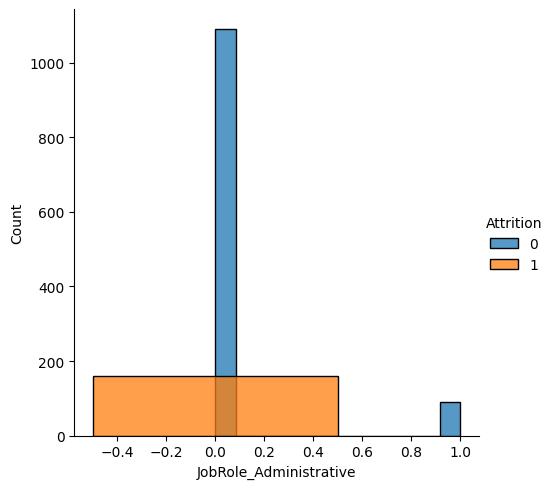

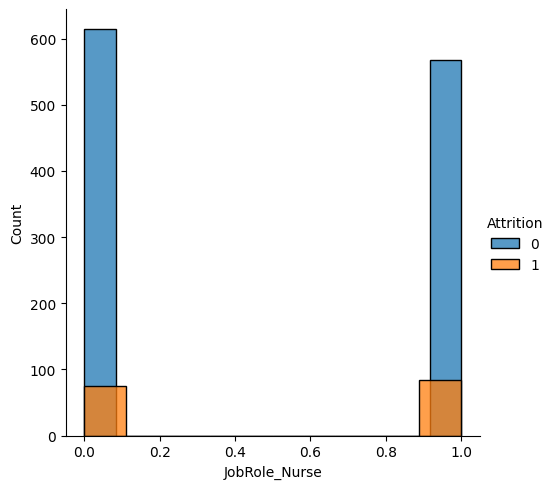

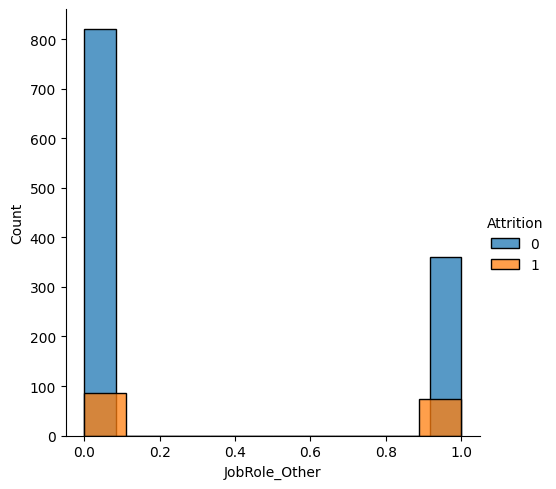

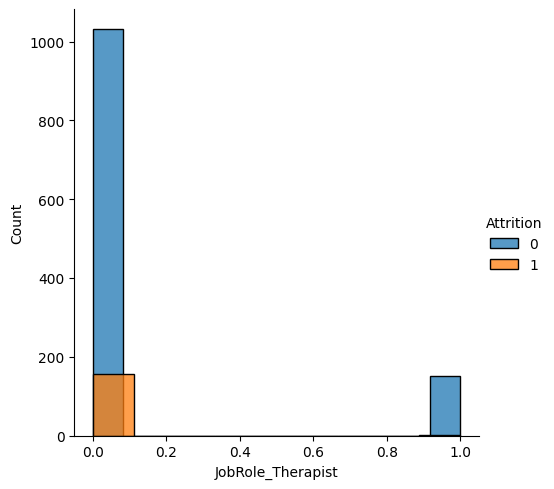

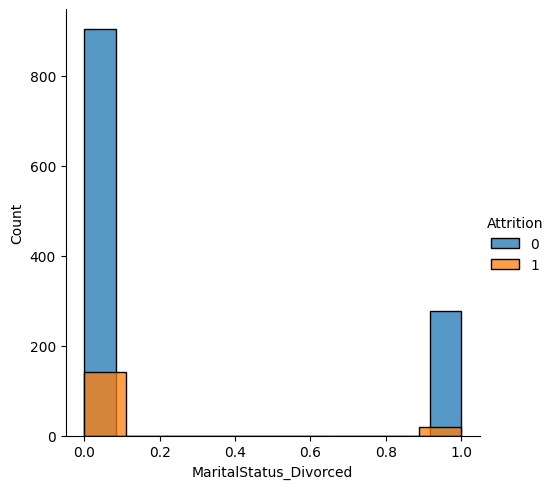

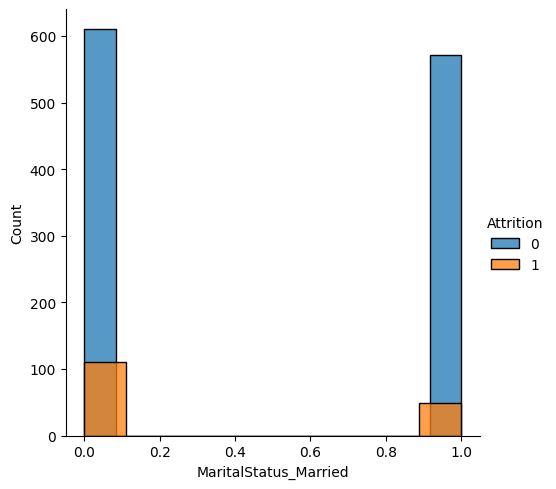

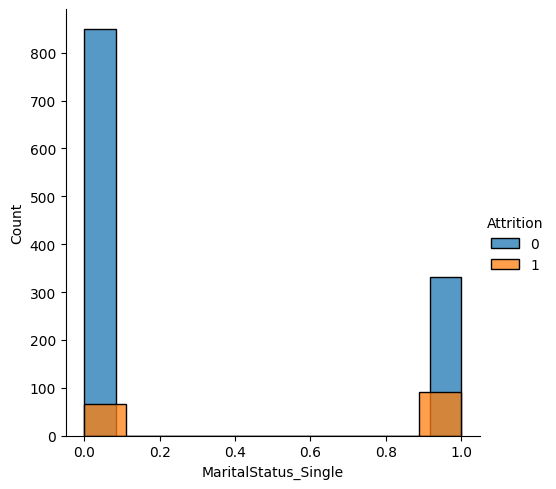

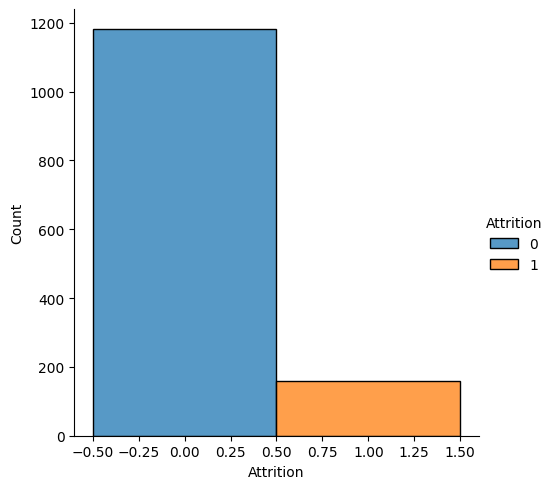

In [161]:
# Histograms for binned data and dummmy data created
promising_data2 = data[data.columns[31:]]
promising_data2 = pd.concat([promising_data2, labels], axis=1)

for c in promising_data2.columns:
    sns.FacetGrid(promising_data2, 
                  hue="Attrition", 
                  height= 5).map(sns.histplot,c).add_legend()


In [162]:
# Feature selection using coefficient weights
estimator = LogisticRegression(max_iter=120)
selector = RFECV(estimator, min_features_to_select=20, 
                 step=1, cv=5)
selector = selector.fit(data, np.ravel(labels))
names = selector.get_feature_names_out()

# See which features are correlated with Attrition
print(data[names].columns)
print(data[names].shape)

Index(['BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'Shift',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Age_Even', 'DailyRate_Even',
       'DistanceFromHome_Even', 'HourlyRate_Even', 'MonthlyIncome_Even',
       'MonthlyRate_Even', 'TotalWorkingYears_Even', 'YearsInCurrentRole_Even',
       'YearsWithCurrManager_Even', 'NumCompaniesWorked_Even',
       'EnvironmentSatisfaction_1', 'EnvironmentSatisfaction_3',
       'EnvironmentSatisfaction_4', 'JobInvolvement_1', 'JobInvolvement_2',
       'JobInvolvement_3', 'JobInvolvement_4', 'JobLevel_1', 'JobLevel_2',
       'JobLevel_3',

In [163]:
# Eliminate redundant features
good_data = data[names]
selected_features = mrmr.mrmr_classif(good_data, 
                                      np.ravel(labels), 
                                      K=20)
print(selected_features)

uncorr_data = good_data[selected_features]
uncorr_sub_data = submission_data[selected_features]

100%|██████████| 20/20 [00:00<00:00, 86.50it/s]

['OverTime', 'JobLevel_1', 'BusinessTravel_Travel_Rarely', 'JobInvolvement', 'Shift_0', 'WorkLifeBalance_1', 'Age_Even', 'DistanceFromHome_Even', 'EnvironmentSatisfaction', 'YearsInCurrentRole', 'MaritalStatus_Single', 'TotalWorkingYears', 'JobSatisfaction', 'JobLevel_2', 'JobInvolvement_1', 'YearsWithCurrManager', 'JobLevel', 'EnvironmentSatisfaction_1', 'TrainingTimesLastYear_2', 'MaritalStatus']


In [164]:
# Save the selected data
fin_data = pd.concat([uncorr_data, labels], axis=1)
fin_data.to_csv("uncorr20_data.csv")
uncorr_sub_data.to_csv("uncorr20_sub_data.csv")

In [165]:
# Feature engineering by making polynomial features
poly = PolynomialFeatures(degree=2)

poly_data = poly.fit_transform(uncorr_data)
poly_sub = poly.fit_transform(uncorr_sub_data)

poly_names = poly.get_feature_names_out()
# print(poly_names)

# print(poly_data.shape)

poly_data = pd.DataFrame(poly_data, columns=poly_names)
poly_sub = pd.DataFrame(poly_sub, columns=poly_names)
# print(poly_data.head())

In [167]:
# Feature selection using coefficient weights
estimator = LogisticRegression(max_iter=120)
selector = RFECV(estimator, min_features_to_select=20, 
                 step=1, cv=5)
selector = selector.fit(poly_data, np.ravel(labels))
names = selector.get_feature_names_out()

print(poly_data[names].columns)
print(poly_data[names].shape)

Index(['OverTime', 'YearsInCurrentRole', 'MaritalStatus_Single',
       'YearsWithCurrManager', 'OverTime^2', 'OverTime JobLevel_1',
       'OverTime YearsInCurrentRole', 'OverTime JobSatisfaction',
       'OverTime EnvironmentSatisfaction_1',
       'OverTime TrainingTimesLastYear_2', 'OverTime MaritalStatus',
       'JobLevel_1 WorkLifeBalance_1', 'JobLevel_1 Age_Even',
       'JobLevel_1 DistanceFromHome_Even', 'JobLevel_1 MaritalStatus_Single',
       'JobLevel_1 EnvironmentSatisfaction_1',
       'BusinessTravel_Travel_Rarely WorkLifeBalance_1',
       'BusinessTravel_Travel_Rarely Age_Even',
       'BusinessTravel_Travel_Rarely DistanceFromHome_Even',
       'BusinessTravel_Travel_Rarely JobInvolvement_1',
       'BusinessTravel_Travel_Rarely JobLevel',
       'BusinessTravel_Travel_Rarely TrainingTimesLastYear_2',
       'BusinessTravel_Travel_Rarely MaritalStatus',
       'JobInvolvement MaritalStatus_Single', 'JobInvolvement JobSatisfaction',
       'JobInvolvement JobLevel_2'

In [169]:
# Eliminate redundant features
good_poly_data = poly_data[names]
selected_features = mrmr.mrmr_classif(good_poly_data, 
                                      np.ravel(labels), 
                                      K=20)
print(selected_features)

uncorr_poly_data = good_poly_data[selected_features]
uncorr_poly_sub_data = poly_sub[selected_features]

100%|██████████| 20/20 [00:00<00:00, 50.45it/s]

['OverTime JobLevel_1', 'Shift_0 EnvironmentSatisfaction_1', 'DistanceFromHome_Even TrainingTimesLastYear_2', 'JobInvolvement JobSatisfaction', 'OverTime MaritalStatus', 'BusinessTravel_Travel_Rarely Age_Even', 'JobLevel_1 MaritalStatus_Single', 'OverTime', 'Shift_0 JobInvolvement_1', 'YearsWithCurrManager', 'OverTime EnvironmentSatisfaction_1', 'JobLevel_1 WorkLifeBalance_1', 'OverTime^2', 'Age_Even EnvironmentSatisfaction', 'Shift_0 DistanceFromHome_Even', 'JobInvolvement JobLevel_2', 'OverTime TrainingTimesLastYear_2', 'YearsInCurrentRole', 'MaritalStatus_Single EnvironmentSatisfaction_1', 'OverTime JobSatisfaction']


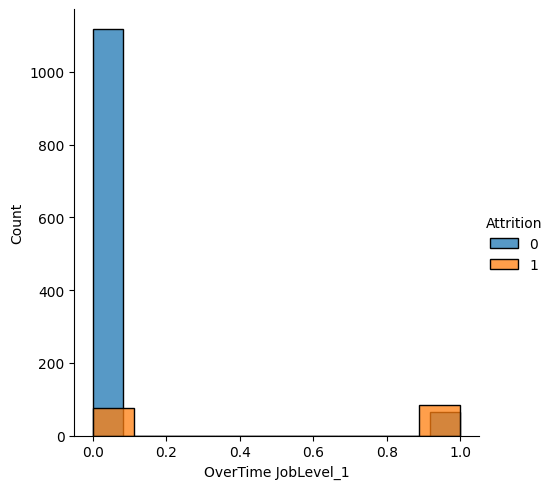

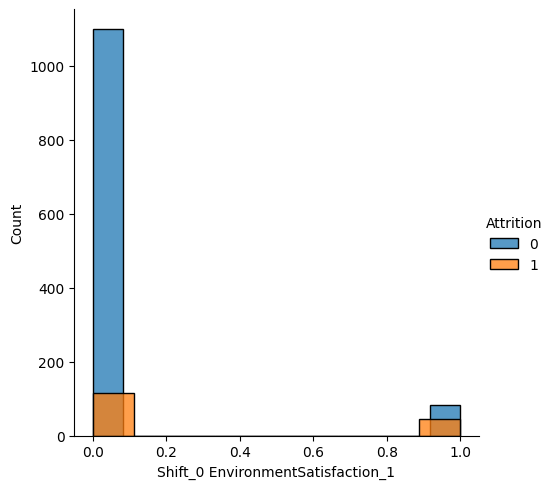

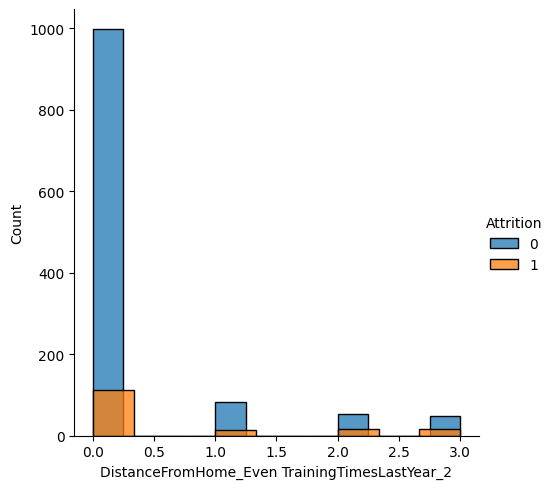

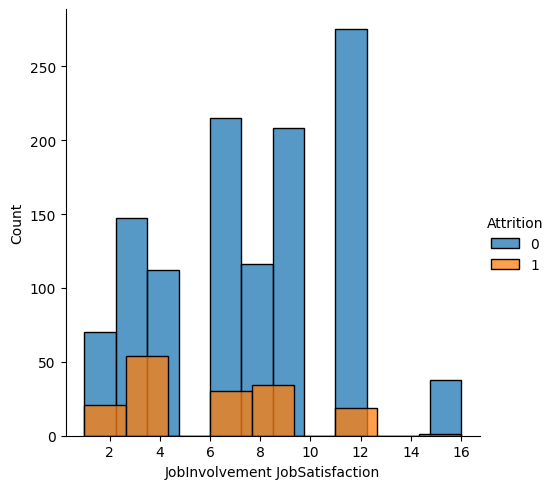

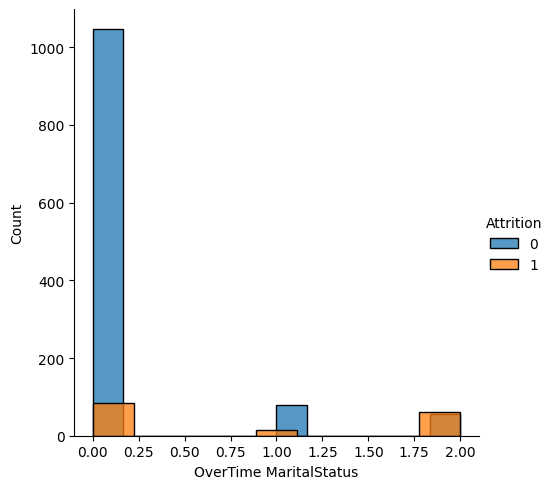

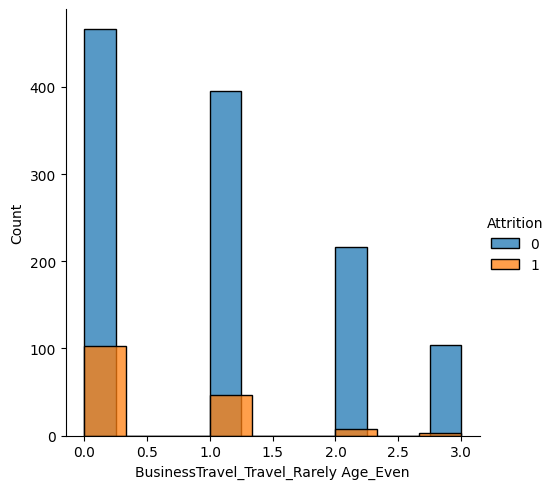

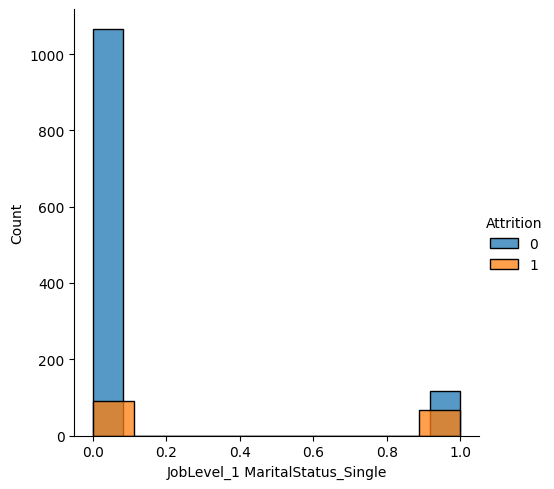

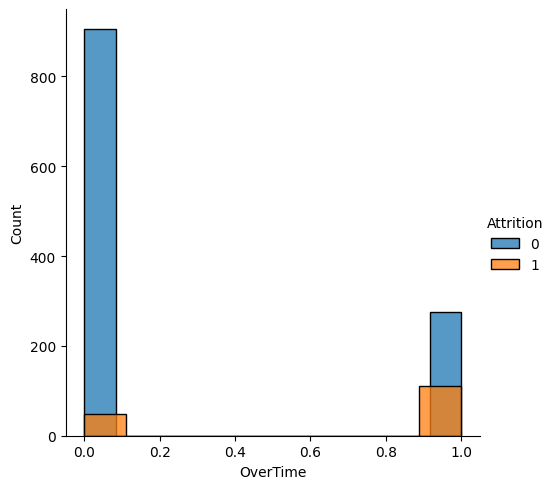

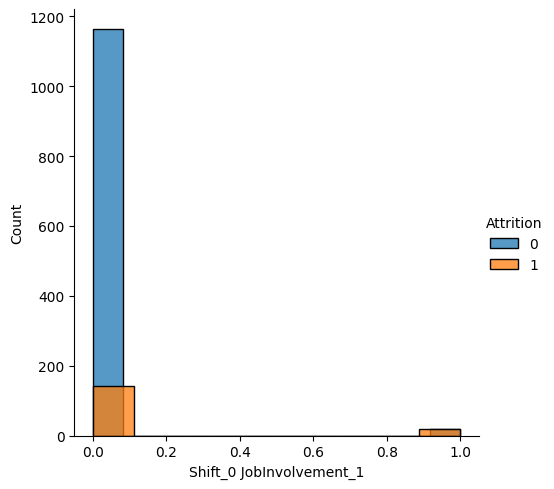

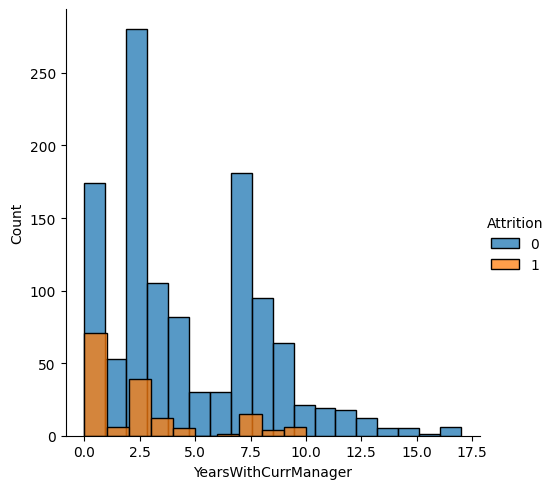

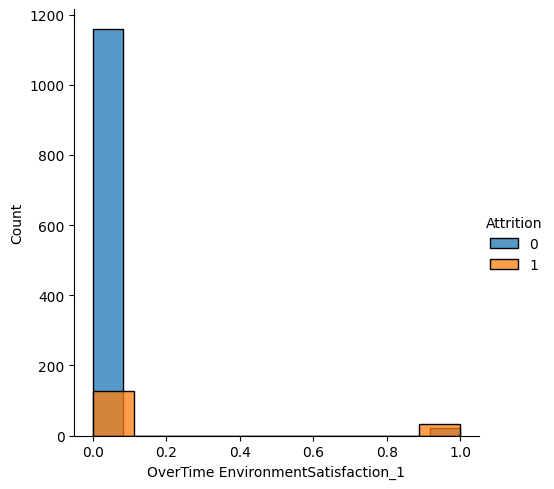

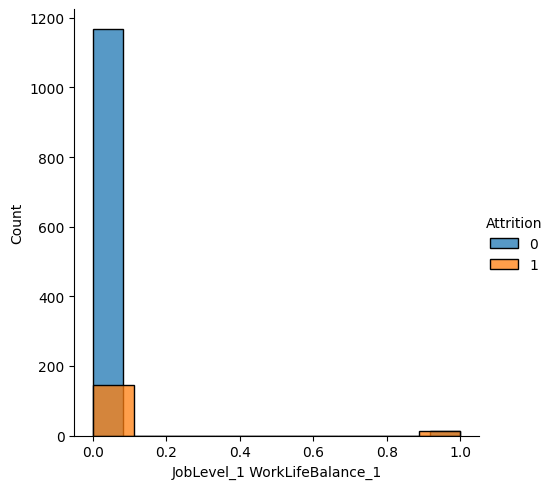

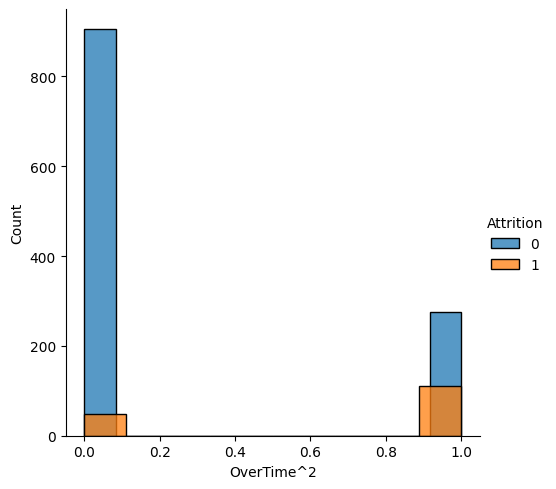

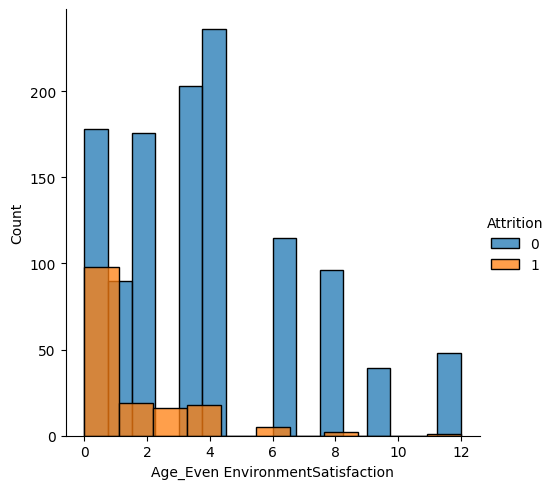

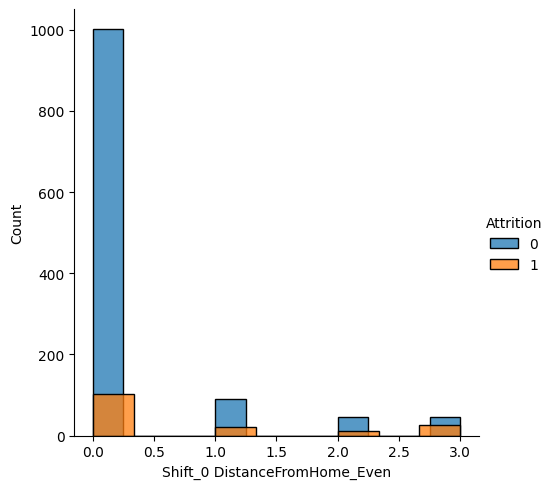

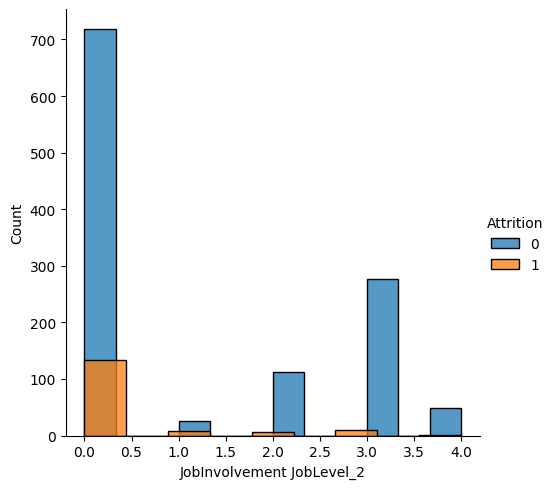

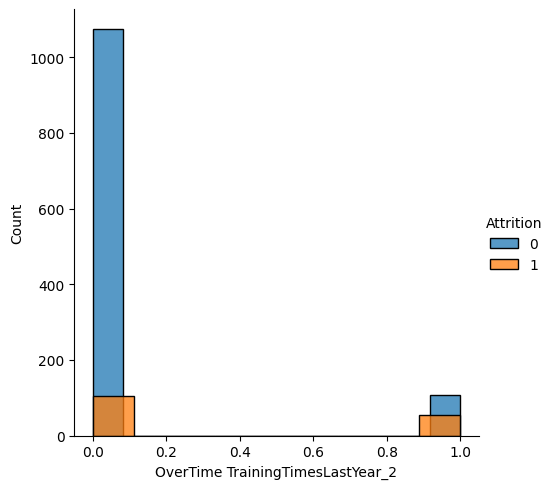

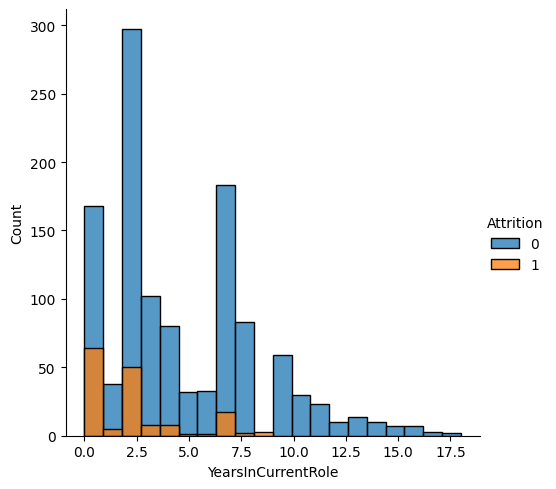

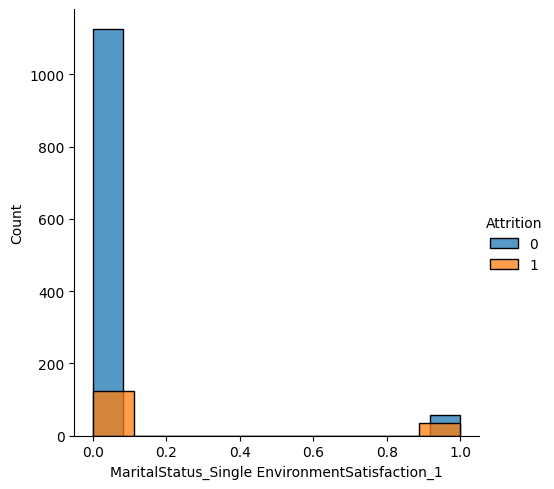

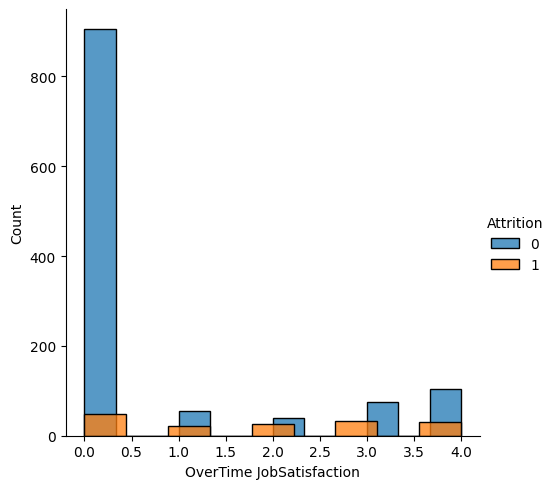

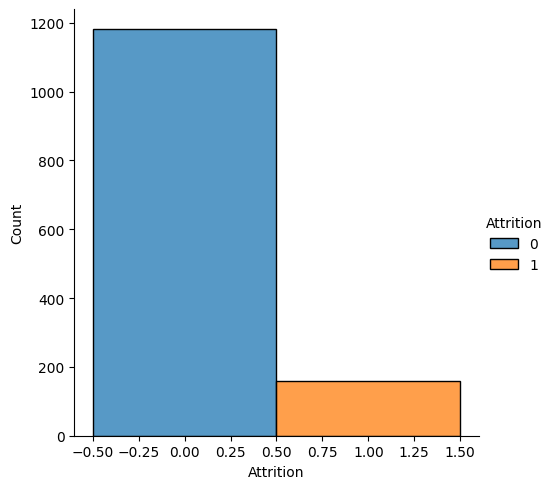

In [170]:
# Generate histograms to check usefulness of features selected
fin_poly_data = pd.concat([uncorr_poly_data, labels], axis=1)
for c in fin_poly_data.columns:
    sns.FacetGrid(fin_poly_data, 
                  hue="Attrition", 
                  height= 5).map(sns.histplot,c).add_legend()

In [171]:
# save the final poly data
fin_poly_data = pd.concat([uncorr_poly_data, labels], axis=1)
fin_poly_data.to_csv("uncorr20_poly_data.csv")
uncorr_poly_sub_data.to_csv("uncorr20_poly_sub_data.csv")